# Model Replication

In [202]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats import multitest
from scipy import stats
from scipy.stats import levene, norm
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
from matplotlib.colors import to_rgb
import colorsys


import itertools

plt.rcParams['figure.dpi'] = 600
colors = plt.colormaps["Dark2"].colors
from tqdm import tqdm

# silence warnings because the NN has a lot of them
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from optuna import create_study
from optuna.trial import Trial
from tensorflow.keras import backend as K
import random

# for saving model params
import pickle

# for feature importance
import shap
from sklearn.metrics import mean_squared_error
import copy
import ast

In [203]:
### CONDITION-LEVEL DATA
df_condition_level_data = pd.read_csv('../outputs/condition_level_group_advantage_with_ivs.csv') # mark's version of the cleaning

# add in categorical task types
df_condition_data_with_mcgrath_types = pd.read_csv('../outputs/condition_level_group_advantage_with_ivs_and_categories.csv')
mcgrath_cols = df_condition_data_with_mcgrath_types.filter(like="Type").columns
df_condition_data_with_mcgrath_types = df_condition_data_with_mcgrath_types[["task"] + list(mcgrath_cols)].drop_duplicates()
# rename the mcgrath columns to have the suffix "_categorical"
df_condition_data_with_mcgrath_types = df_condition_data_with_mcgrath_types.rename(columns={col: col + "_categorical" for col in mcgrath_cols})
df_condition_level_data = df_condition_level_data.merge(df_condition_data_with_mcgrath_types, on="task", how="left")

In [204]:
# inspect data, just to get a sense of the range of values.
df_condition_level_data[["task", "strong", "High", "Medium", "Low"]].sort_values("strong", ascending=False)

task    strong  High  Medium  Low
39   Putting Food Into Categories  1.659080     0       1    0
113             Word Construction  1.627765     1       0    0
80               Unscramble Words  1.627760     0       1    0
37   Putting Food Into Categories  1.606875     0       0    1
41   Putting Food Into Categories  1.534374     1       0    0
..                            ...       ...   ...     ...  ...
5           Advertisement Writing  0.443447     1       0    0
3           Advertisement Writing  0.417235     0       1    0
89                    Whac a Mole  0.331275     1       0    0
45              Random Dot Motion  0.297844     0       1    0
87                    Whac a Mole  0.261190     0       1    0

[120 rows x 5 columns]

In [205]:
df_observation_level_data = pd.read_csv('../outputs/observation_level_dv_with_composition.csv')

In [206]:
FOCAL_DEMOGRAPHIC_COLS = ['IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR', 'IRCS_IV', 'IRCS_RS',
                        'RME', 'CRT', 'birth_year', 'education_level', 'income_max', 'political_fiscal', 'political_party', 'political_social',
                        'gender', 'race', 'marital_status']

COMPOSITION_IVS = [col for col in df_observation_level_data.columns if any(col.startswith(prefix) for prefix in FOCAL_DEMOGRAPHIC_COLS)]
COMPOSITION_IVS = COMPOSITION_IVS + ["playerCount", "Low", "Medium", "High"]

# p-value check: Within-Task Type Variance

"...there is almost as much within-category variation as exists overall."

In [207]:
mcgrath_cat_cols = df_condition_data_with_mcgrath_types.filter(like="_cat").columns
cat_col = df_condition_level_data[mcgrath_cat_cols].idxmax(axis=1)
df_condition_level_data_with_cat = df_condition_level_data.assign(cat_col=cat_col)

# Aggregate and summarize data by category
categorical_condition_summary = df_condition_level_data_with_cat.groupby("cat_col").agg({
    "strong": ["mean", "std", "count"],
    "weak": ["mean", "std", "count"]
}).reset_index()

# categorical level summary
display(categorical_condition_summary)

# display the strong and weak values for the entire dataset
display(df_condition_level_data["strong"].describe())
display(df_condition_level_data["weak"].describe())

strong_vals = df_condition_level_data["strong"]
weak_vals = df_condition_level_data["weak"]

strong_test_stats = []
weak_test_stats = []
strong_p_vals = []
weak_p_vals = []
df1_list = []
df2_list = []

# Iterate over each unique category to apply Levene's test
for cat in categorical_condition_summary['cat_col']:
    category_data = df_condition_level_data_with_cat[df_condition_level_data_with_cat['cat_col'] == cat]
    
    if category_data["strong"].count() > 6:
        cat_strong_vals = category_data["strong"]
        cat_weak_vals = category_data["weak"]

        # Levene's test comparing group variance to overall variance
        """
        The Levene test tests the null hypothesis that all input samples 
        are from populations with equal variances. Levene’s test is an 
        alternative to Bartlett’s test bartlett in the case where there 
        are significant deviations from normality.

        Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html

        """
        W_stat_strong, p_val_strong = levene(cat_strong_vals, strong_vals)
        W_stat_weak, p_val_weak = levene(cat_weak_vals, weak_vals)

        # degrees of freedom
        """
        The degree of freedom df1 is obtained by calculating the number of groups minus 1,
        the degree of freedom df2 is obtained by calculating the number of cases minus the 
        number of groups.  Source: https://datatab.net/tutorial/levene-test
        """
        NUM_GROUPS = 2
        df1_list.append(NUM_GROUPS - 1)
        df2_list.append(len(cat_strong_vals) + len(strong_vals) - NUM_GROUPS)
        assert(len(cat_weak_vals) == len(cat_strong_vals)) # means we only need to calculate df once
        assert(len(strong_vals) == len(weak_vals))

        strong_test_stats.append(W_stat_strong)
        weak_test_stats.append(W_stat_weak)
        strong_p_vals.append(p_val_strong)
        weak_p_vals.append(p_val_weak)
    else:
        strong_test_stats.append(None)
        weak_test_stats.append(None)
        strong_p_vals.append(None)
        weak_p_vals.append(None)
        df1_list.append(None)
        df2_list.append(None)

result_summary = categorical_condition_summary.assign(
    strong_W_stat=strong_test_stats, 
    strong_p_value=strong_p_vals, 
    weak_W_stat=weak_test_stats, 
    weak_p_value=weak_p_vals,
    df1 = df1_list,
    df2 = df2_list
)
display(result_summary)

cat_col    strong                  \
                                                mean       std count   
0            Type 2 (Generate)_categorical  1.040283  0.333841    30   
1        Type 3 (Intellective)_categorical  0.953430  0.227294    66   
2     Type 4 (Decision-Making)_categorical  0.689811  0.060508     6   
3  Type 5 (Cognitive Conflict)_categorical  0.671171  0.104386     6   
4         Type 8 (Performance)_categorical  0.837984  0.366415    12   

       weak                  
       mean       std count  
0  1.725222  0.808108    30  
1  1.547579  0.586886    66  
2  1.024908  0.122569     6  
3  1.207868  0.117462     6  
4  1.521116  0.608324    12

count    120.000000
mean       0.936305
std        0.280842
min        0.261190
25%        0.801759
50%        0.920559
75%        1.001102
max        1.659080
Name: strong, dtype: float64

count    120.000000
mean       1.546224
std        0.640559
min        0.587855
25%        1.116857
50%        1.304525
75%        1.720179
max        3.730325
Name: weak, dtype: float64

cat_col    strong                  \
                                                mean       std count   
0            Type 2 (Generate)_categorical  1.040283  0.333841    30   
1        Type 3 (Intellective)_categorical  0.953430  0.227294    66   
2     Type 4 (Decision-Making)_categorical  0.689811  0.060508     6   
3  Type 5 (Cognitive Conflict)_categorical  0.671171  0.104386     6   
4         Type 8 (Performance)_categorical  0.837984  0.366415    12   

       weak                 strong_W_stat strong_p_value weak_W_stat  \
       mean       std count                                            
0  1.725222  0.808108    30      1.011807       0.316112    2.139709   
1  1.547579  0.586886    66      3.383290       0.067472    0.426800   
2  1.024908  0.122569     6           NaN            NaN         NaN   
3  1.207868  0.117462     6           NaN            NaN         NaN   
4  1.521116  0.608324    12      3.606798       0.059760    0.074308   

  weak_p_value  df1    df2  
                            
0     0.145649  1.0  148.0  
1     0.514379  1.0  184.0  
2          NaN  NaN    NaN  
3          NaN  NaN    NaN  
4     0.785598  1.0  130.0

## Complexity interaction patterns

For instance, in Whac-A-Mole, groups display weak advantage at low levels of complexity, but their advantage decreases as the complexity increases. Likewise, the Putting Food into Categories task shows a strong interaction with group size, in which larger groups demonstrate more advantage than smaller ones, regardless of the level of complexity. But all of these interaction patterns are heterogeneous across the 20 tasks in our corpus.

In [208]:
for task in df_observation_level_data["task"].unique():

    print("****Results for Task: " +  task + " ****")

    task_data = df_observation_level_data[df_observation_level_data["task"] == task]
    
    # turn the categories ["Low", "Medium", and "High"] into an ordinal variable in the df task_data
    task_data['task_complexity'] = 1 * task_data['Low'] + 2 * task_data['Medium'] + 3 * task_data['High']

    # Fit a regression of Group Advantage ~ Task Complexity + Group Size with a random effect for group ID
    strong_model = sm.MixedLM.from_formula("strong ~ task_complexity + playerCount", groups="playerIds", data=task_data)
    strong_result = strong_model.fit()
    print("===Strong Group Advantage===")
    print(strong_result.summary())

    weak_model = sm.MixedLM.from_formula("weak ~ task_complexity + playerCount", groups="playerIds", data=task_data)
    weak_result = weak_model.fit()
    print("===Weak Group Advantage===")
    print(weak_result.summary())

****Results for Task: Unscramble Words ****
===Strong Group Advantage===
          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  strong  
No. Observations:   159      Method:              REML    
No. Groups:         53       Scale:               0.1029  
Min. group size:    3        Log-Likelihood:      -51.8359
Max. group size:    3        Converged:           No      
Mean group size:    3.0                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        1.202    0.101 11.920 0.000  1.004  1.400
task_complexity  0.083    0.031  2.674 0.008  0.022  0.144
playerCount     -0.023    0.017 -1.363 0.173 -0.057  0.010
playerIds Var    0.000    0.039                           

===Weak Group Advantage===
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent 

# Figure 2

### Data Structure for Storing the Final Models & Outputs

In [209]:
base_model = {
            "OLS": {
                "Wave 1a": {"strong": None, "weak": None},
                "Wave 1": {"strong": None, "weak": None},
                "Wave 2": {"strong": None, "weak": None}
            },
            "E-Net": {
                "Wave 1a": {"strong": None, "weak": None},
                "Wave 1": {"strong": None, "weak": None},
                "Wave 2": {"strong": None, "weak": None}
            },
            "NN": {
                "Wave 1a": {"strong": None, "weak": None},
                "Wave 1": {"strong": None, "weak": None},
                "Wave 2": {"strong": None, "weak": None}
            }
        }

In [210]:
# 2 (types of predictors) x 3 (models) x 3 (waves for training data) = 18 models
try:
    # read the models and results from the previous save
    with open('../outputs/models.pkl', 'rb') as f:
        MODELS = pickle.load(f)
    with open('../outputs/model_r2_results.pkl', 'rb') as f:
        MODEL_R2_RESULTS = pickle.load(f)
    with open('../outputs/model_rmse_results.pkl', 'rb') as f:
        MODEL_RMSE_RESULTS = pickle.load(f)

except FileNotFoundError:
    # if the file is not found, we will create the MODELS and MODEL_R2_RESULTS dictionaries
    MODELS = {
        "Task Space": copy.deepcopy(base_model),
        "McGrath Categorical": copy.deepcopy(base_model),
        "McGrath Subspace": copy.deepcopy(base_model),
        "Steiner Subspace": copy.deepcopy(base_model),
        "Laughlin Subspace": copy.deepcopy(base_model)
    }

    # create a dictionary with the sake keys as MODELS to story R2 results
    MODEL_R2_RESULTS = copy.deepcopy(MODELS)

    # create a dictionary with the sake keys as MODELS to story RMSE results
    MODEL_RMSE_RESULTS = copy.deepcopy(MODELS)

In [211]:
# save MODELS and MODEL_R2_RESULTS
def save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS, MODEL_RMSE_RESULTS):
    with open('../outputs/models.pkl', 'wb') as f:
        pickle.dump(MODELS, f)
    with open('../outputs/model_r2_results.pkl', 'wb') as f:
        pickle.dump(MODEL_R2_RESULTS, f)
    with open('../outputs/model_rmse_results.pkl', 'wb') as f:
        pickle.dump(MODEL_RMSE_RESULTS, f)

# Linear Models

In [212]:
#  Create a "Wave 1a that holds out half of Wave 1"
wave1_tasks = df_condition_level_data[df_condition_level_data['wave']==1]['task'].unique()

# Set a random seed for reproducibility, then select half the wave 1 tasks
random.seed(19104)
wave1a_tasks = random.sample(list(wave1_tasks), len(wave1_tasks) // 2)
wave1b_tasks = [task for task in wave1_tasks if task not in wave1a_tasks]

In [213]:
# Hold out 15 tasks
wave1a_df_train = df_condition_level_data[df_condition_level_data["task"].isin(wave1a_tasks)] ## train on this
wave1a_df_test = df_condition_level_data[~df_condition_level_data["task"].isin(wave1a_tasks)] ## test on everything else

# Hold out 10 tasks
wave1_df_train = df_condition_level_data[df_condition_level_data["wave"] == 1] ## train on this
wave1_df_test = df_condition_level_data[df_condition_level_data["wave"] > 1] ## test on everything else

# Hold out 5 tasks
wave12_df_train = df_condition_level_data[df_condition_level_data["wave"] <= 2] ## then train on this
wave12_df_test = df_condition_level_data[df_condition_level_data["wave"] == 3] ## test on everything else

In [214]:
# datastructure for the training and testing data
TRAIN_TEST_DATA = {
    "Wave 1a": {
        "train": wave1a_df_train,
        "test": wave1a_df_test
    },
    "Wave 1": {
        "train": wave1_df_train,
        "test": wave1_df_test
    },
    "Wave 2": {
        "train": wave12_df_train,	
        "test": wave12_df_test
    }
}

In [215]:
# lists of IV's
basic_IVs = [col for col in df_condition_level_data.columns if 
    "categorical" not in col and "task" not in col and "strong" not in col and "weak" not in col and "wave" not in col]

mcgrath_continuous = [col for col in basic_IVs if "Type" in col] + ["Conceptual-Behavioral"]

steiner_continuous = ["Divisible-Unitary", "Maximizing", "Optimizing"]

laughlin_continuous = ["Decision Verifiability", "Shared Knowledge", "Within-System Solution", "Answer Recognizability", "Time Solvability", "Intellective-Judgmental", "Eureka Question"]

categorical_IVs = [col for col in df_condition_level_data.columns if "categorical" in col] + ["playerCount", "Low", "Medium", "High"]

Functions to train on one wave and test on another

In [216]:
def get_rmse(y_true, y_pred):
    """
    Calculate RMSE between true and predicted values.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# function for getting RMSE from a trained model (OLS)
def get_rmse_ols(model_ols, X_test, y_true, ivs):
    X_test_ols = sm.add_constant(X_test[ivs].copy(), has_constant='add')
    y_pred_ols = model_ols.predict(X_test_ols)
    rmse_ols = get_rmse(y_true, y_pred_ols)

    return rmse_ols

In [217]:
def train_wave_a(wave_a_data, dv_type, ivs):
    assert dv_type in ["strong", "weak"]
    X = wave_a_data[ivs]
    X = sm.add_constant(X, has_constant='add')
    y = wave_a_data[dv_type]
    return sm.OLS(y, X).fit()

def custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type):
    # Compute R^2 on the test set, using the training set as a baseline
    naive_prediction_errs = []
    for i, row in wave_b_data.iterrows():
        
        # get all instances of groups of the same size performing 
        # all the tasks in the training set at the same complexity level.
        playerCount = row["playerCount"]
        wave_a_subset = wave_a_data[(wave_a_data["playerCount"] == playerCount) & 
                                    (wave_a_data["Low"] == row["Low"]) & 
                                    (wave_a_data["Medium"] == row["Medium"]) &
                                    (wave_a_data["High"] == row["High"])]
        y_training = np.mean(wave_a_subset[dv_type])
        # predict the value of the DV (in wave_b) using the mean of the training data (from wave_a)
        y_actual_i = row[dv_type]
        fold_err = (y_actual_i - y_training)**2
        naive_prediction_errs.append(fold_err)

    r2 = 1 - np.sum((y_pred - y_actual)**2) / np.sum(naive_prediction_errs)
    
    return r2

def test_wave_b(wave_a_data, wave_b_data, model, dv_type, ivs):
    assert dv_type in ["strong", "weak"]
    
    X = wave_b_data[ivs]
    X = sm.add_constant(X, has_constant='add')
    y_actual = wave_b_data[dv_type]
    y_pred = model.predict(X)
    r2 = custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type)
    
    return r2, y_actual, y_pred

def plot_results(y_actual, y_pred, y_train, r2, title="Model Results (Figure 2)"):
    min_val = min(0, 0) # fix at 0,0
    larger_max_val = max(y_actual.max(), y_pred.max())
    round_max_val = round(larger_max_val, 0)
    max_val = max(round_max_val, round_max_val) # the larger max value (between the predicted and the actual)
    
    plt.scatter(y_actual, y_pred)
    plt.axhline(y_train.mean(), color='r', linestyle='-')

    # plot y=x line
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    plt.text(0.1, 0.9, f"$R^2$ = {r2:.2f}", transform=plt.gca().transAxes, fontsize=20)

    plt.xlim(min_val, max_val) # gotta make sure the lims are the same
    plt.ylim(min_val, max_val)
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def train_wave_a_test_wave_b(wave_a_data, wave_b_data, dv_type, ivs, title, plot = False):
    model = train_wave_a(wave_a_data, dv_type, ivs)
    r2, y, y_pred = test_wave_b(wave_a_data, wave_b_data, model, dv_type, ivs)
    if plot:
        # plot the results; defaults to false because it gets a little overwhelming :)
        plot_results(y, y_pred, wave_a_data[dv_type], r2, title)
    return model, r2

### Build our Linear Models

In [218]:
for wave in TRAIN_TEST_DATA.keys():
    for model_type in MODELS.keys():
        for dv_type in ["strong", "weak"]:
            # if the model for this wave and dv_type is not trained yet, train it
            if not MODELS[model_type]["OLS"][wave][dv_type] or not MODEL_R2_RESULTS[model_type]["OLS"][wave][dv_type]:

                # get the training and testing data
                wave_a_data = TRAIN_TEST_DATA[wave]["train"]
                wave_b_data = TRAIN_TEST_DATA[wave]["test"]

                if model_type == "Task Space":
                    ivs = basic_IVs
                elif model_type == "McGrath Categorical":
                    ivs = categorical_IVs
                elif model_type == "McGrath Subspace":
                    ivs = mcgrath_continuous
                elif model_type == "Steiner Subspace":
                    ivs = steiner_continuous
                elif model_type == "Laughlin Subspace":
                    ivs = laughlin_continuous
                else:
                    raise ValueError("Unknown model type: {}".format(model_type))

                # train the model and test it
                model, r2 = train_wave_a_test_wave_b(wave_a_data, wave_b_data, dv_type, ivs, 
                                                    f"{model_type} {dv_type} {wave}", plot=False)
                
                rmse = get_rmse_ols(model, wave_b_data, wave_b_data[dv_type], ivs)
                
                # store the results
                MODELS[model_type]["OLS"][wave][dv_type] = model
                MODEL_R2_RESULTS[model_type]["OLS"][wave][dv_type] = r2
                MODEL_RMSE_RESULTS[model_type]["OLS"][wave][dv_type] = rmse
                save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS, MODEL_RMSE_RESULTS)

# ElasticNet Models

In [219]:
def add_interactions(X):
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    return poly.fit_transform(X)

def get_rmse_for_enet(model_enet, X_test, y_true, ivs):
    X_test_enet = add_interactions(X_test[ivs].copy())
    y_pred_enet = model_enet.predict(X_test_enet)
    rmse_enet = get_rmse(y_true, y_pred_enet)

    return rmse_enet

def train_wave_a_enet(wave_a_data, dv_type, ivs, random_state=19104):
    assert dv_type in ["strong", "weak"]
    X = wave_a_data[ivs]
    X_interactions = add_interactions(X)
    y = wave_a_data[dv_type]
    
    # Define a range of values for alpha and l1_ratio
    alphas = np.logspace(-4, 1, 50)
    l1_ratio = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

    # Initialize and fit ElasticNetCV
    elastic_net_cv = ElasticNetCV(cv=5, alphas=alphas, l1_ratio=l1_ratio, random_state=random_state)
    elastic_net_cv.fit(X_interactions, y)
    
    # Re-fit the model on the full training dataset using the best hyperparameters
    elastic_net = ElasticNet(alpha=elastic_net_cv.alpha_, l1_ratio=elastic_net_cv.l1_ratio_)
    elastic_net.fit(X_interactions, y)
    
    return elastic_net

def test_wave_b_enet(wave_a_data, wave_b_data, model, dv_type, ivs):
    assert dv_type in ["strong", "weak"]
    
    X = wave_b_data[ivs]
    X_interactions = add_interactions(X)
    y_actual = wave_b_data[dv_type]
    y_pred = model.predict(X_interactions)
    
    r2 = custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type)
    
    return r2, y_actual, y_pred

def train_wave_a_test_wave_b_enet(wave_a_data, wave_b_data, dv_type, ivs, title, plot=False):
    model = train_wave_a_enet(wave_a_data, dv_type, ivs)
    r2, y_actual, y_pred = test_wave_b_enet(wave_a_data, wave_b_data, model, dv_type, ivs)
    if plot:
        plot_results(y_actual, y_pred, wave_a_data[dv_type], r2, title)
    return model, r2

### Build our ENet Models

In [220]:
for wave in tqdm(TRAIN_TEST_DATA.keys(), desc="Waves"):
    for model_type in MODELS.keys():
        for dv_type in ["strong", "weak"]:
            
            if not MODELS[model_type]["E-Net"][wave][dv_type] or not MODEL_R2_RESULTS[model_type]["E-Net"][wave][dv_type]:
                # Get the training and testing data
                wave_a_data = TRAIN_TEST_DATA[wave]["train"]
                wave_b_data = TRAIN_TEST_DATA[wave]["test"]

                if model_type == "Task Space":
                    ivs = basic_IVs
                elif model_type == "McGrath Categorical":
                    ivs = categorical_IVs
                elif model_type == "McGrath Subspace":
                    ivs = mcgrath_continuous
                elif model_type == "Steiner Subspace":
                    ivs = steiner_continuous
                elif model_type == "Laughlin Subspace":
                    ivs = laughlin_continuous
                else:
                    raise ValueError("Unknown model type: {}".format(model_type))

                # Train the model and test it
                model, r2 = train_wave_a_test_wave_b_enet(wave_a_data, wave_b_data, dv_type, ivs, 
                                                        f"{model_type} {dv_type} {wave}", plot=False)
                rmse = get_rmse_for_enet(model, wave_b_data, wave_b_data[dv_type], ivs)
                
                # Store the results
                MODELS[model_type]["E-Net"][wave][dv_type] = model
                MODEL_R2_RESULTS[model_type]["E-Net"][wave][dv_type] = r2
                MODEL_RMSE_RESULTS[model_type]["E-Net"][wave][dv_type] = rmse
                save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS, MODEL_RMSE_RESULTS)

                # Optional: Print progress information
                print(f"Completed: {model_type} - {dv_type} - {wave}")

Waves:   0%|          | 0/3 [00:00<?, ?it/s]

Completed: Task Space - strong - Wave 1a
Completed: Task Space - weak - Wave 1a
Completed: McGrath Categorical - strong - Wave 1a
Completed: McGrath Categorical - weak - Wave 1a
Completed: McGrath Subspace - strong - Wave 1a
Completed: McGrath Subspace - weak - Wave 1a
Completed: Steiner Subspace - strong - Wave 1a
Completed: Steiner Subspace - weak - Wave 1a
Completed: Laughlin Subspace - strong - Wave 1a


Waves:  33%|███▎      | 1/3 [00:34<01:08, 34.10s/it]

Completed: Laughlin Subspace - weak - Wave 1a
Completed: Task Space - strong - Wave 1
Completed: Task Space - weak - Wave 1
Completed: McGrath Categorical - strong - Wave 1
Completed: McGrath Categorical - weak - Wave 1
Completed: McGrath Subspace - strong - Wave 1
Completed: McGrath Subspace - weak - Wave 1
Completed: Steiner Subspace - strong - Wave 1
Completed: Steiner Subspace - weak - Wave 1
Completed: Laughlin Subspace - strong - Wave 1


Waves:  67%|██████▋   | 2/3 [01:55<01:02, 62.01s/it]

Completed: Laughlin Subspace - weak - Wave 1
Completed: Task Space - strong - Wave 2
Completed: Task Space - weak - Wave 2
Completed: McGrath Categorical - strong - Wave 2
Completed: McGrath Categorical - weak - Wave 2
Completed: McGrath Subspace - strong - Wave 2
Completed: McGrath Subspace - weak - Wave 2
Completed: Steiner Subspace - strong - Wave 2
Completed: Steiner Subspace - weak - Wave 2
Completed: Laughlin Subspace - strong - Wave 2


Waves: 100%|██████████| 3/3 [03:45<00:00, 75.06s/it]

Completed: Laughlin Subspace - weak - Wave 2


# Neural Network Models

In [221]:
# def create_model(trial: Trial, input_shape):
#     # hyperparameters from Mark's comment
#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-1)
#     n_units = trial.suggest_int("n_units", 32, 512)
#     n_layers = trial.suggest_categorical("n_layers", [1, 2, 3, 4, 5])
#     batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
#     dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.3)
#     activation = trial.suggest_categorical("activation", ['relu'])

#     # Build model
#     model = Sequential()
#     model.add(Dense(n_units, activation=activation, input_shape=input_shape))
    
#     for _ in range(1, n_layers):
#         model.add(Dense(n_units, activation=activation))
#         model.add(Dropout(dropout_rate))

#     model.add(Dense(1))
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                    loss='mean_squared_error')
    
#     return model, batch_size

# def leave_one_task_out(df, model_func, iv, dv):
#     # assert that dv is one of 'strong' or 'weak'
#     assert dv in ["strong", "weak"]

#     tasks = df["task"].unique()
#     total_left_out_loss = 0

#     for task in tasks:
#         train_data = df[df["task"] != task]
#         test_data = df[df["task"] == task]
        
#         X_train, y_train = train_data[iv], train_data[dv]
#         X_test, y_test = test_data[iv], test_data[dv]

#         input_shape = (X_train.shape[1],)
#         model, batch_size = model_func(input_shape)
        
#         model.fit(X_train, y_train, batch_size=batch_size, epochs=100, verbose=0)
#         loss = model.evaluate(X_test, y_test, verbose=0)
        
#         total_left_out_loss += loss

#     return total_left_out_loss

# """Define objectives"""
# def objective(trial, wave_data, iv, dv):
#     def model_func(input_shape):
#         return create_model(trial, input_shape)
#     total_loss = leave_one_task_out(wave_data, model_func, iv=iv, dv=dv)
#     return total_loss

# def optimize_and_save(study_name, wave_data, iv, dv):
#     try:
#         # Load the hyperparameters from the .pkl file
#         with open(f"../outputs/best_param_pkls/best_params_{study_name}.pkl", "rb") as f:
#             best_params = pickle.load(f)
#     except FileNotFoundError:
#         study = create_study(direction="minimize")
#         study.optimize(lambda trial: objective(trial, wave_data, iv, dv), n_trials=100)

#         best_trial = study.best_trial
#         best_params = best_trial.params
#         # Save the hyperparameters to a .pkl file
#         with open(f"../outputs/best_param_pkls/best_params_{study_name}.pkl", "wb") as f:
#             pickle.dump(best_params, f)

#     return best_params

def set_random_seeds(seed_value=19104):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# def create_best_model(input_shape, best_params):    
#     learning_rate = best_params['learning_rate']
#     n_units = best_params['n_units']
#     n_layers = best_params['n_layers']
#     batch_size = best_params['batch_size']
#     dropout_rate = best_params['dropout_rate']
#     activation = best_params['activation']
    
#     # Build model
#     model = Sequential()
#     model.add(Dense(n_units, activation=activation, input_shape=input_shape))
    
#     for _ in range(1, n_layers):
#         model.add(Dense(n_units, activation=activation))
#         model.add(Dropout(dropout_rate))
    
#     model.add(Dense(1))
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                   loss='mean_squared_error')
    
#     return model, batch_size

In [222]:
# def train_wave_a_nn(wave_a_data, ivs, dv_type):
#     assert dv_type in ["strong", "weak"]

#     # Random seed for reproducibility
#     set_random_seeds()

#     # Objective function for Optuna
#     def objective(trial):
#         return leave_one_task_out(wave_a_data, lambda shape: create_model(trial, shape), ivs, dv_type)

#     # Hyperparameter optimization
#     study = create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)

#     best_params = study.best_trial.params

#     input_shape = (wave_a_data[ivs].shape[1],)
#     model, batch_size = create_best_model(input_shape, best_params)
    
#     X_train = wave_a_data[ivs]
#     y_train = wave_a_data[dv_type]

#     model.fit(X_train, y_train, batch_size=batch_size, epochs=100, verbose=0)

#     print(f"Best hyperparameters: {best_params}")

#     return model

# def test_wave_b_nn(wave_a_data, wave_b_data, model, ivs, dv_type):
#     X_new = wave_b_data[ivs]
#     y_actual = wave_b_data[dv_type]

#     # Ensure consistent shape
#     if len(X_new.shape) == 1:
#         X_new = X_new.reshape(-1, 1)

#     y_pred = model.predict(X_new).flatten()

#     r2 = custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type)

#     return r2, y_actual, y_pred

### Build our NN models

In [223]:
# commenting out because these take too long...

# for wave in tqdm(TRAIN_TEST_DATA.keys(), desc="Waves"):
# 	for model_type in tqdm(MODELS.keys(), desc="Model Types", leave=False):
# 		for dv_type in tqdm(["strong", "weak"], desc="DV Types", leave=False):

# 			if not MODELS[model_type]["NN"][wave][dv_type] or not MODEL_R2_RESULTS[model_type]["NN"][wave][dv_type]:
# 				wave_a_data = TRAIN_TEST_DATA[wave]["train"]
# 				wave_b_data = TRAIN_TEST_DATA[wave]["test"]

# 				if model_type == "Task Space":
# 					ivs = basic_IVs
# 				elif model_type == "McGrath Categorical":
# 					ivs = categorical_IVs
# 				elif model_type == "McGrath Subspace":
# 					ivs = mcgrath_continuous
# 				elif model_type == "Steiner Subspace":
# 					ivs = steiner_continuous
# 				elif model_type == "Laughlin Subspace":
# 					ivs = laughlin_continuous
# 				else:
# 					raise ValueError("Unknown model type: {}".format(model_type))

# 				model = train_wave_a_nn(wave_a_data, ivs, dv_type)
# 				r2, y_actual, y_pred = test_wave_b_nn(wave_a_data, wave_b_data, model, ivs, dv_type)
# 				
# TODO: CREATE AN RMSE FUNCTION! rmse = get_rmse_nn(y_actual, y_pred)       

# 				MODELS[model_type]["NN"][wave][dv_type] = model
# 				MODEL_R2_RESULTS[model_type]["NN"][wave][dv_type] = r2
# 				save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS, MODEL_RMSE_RESULTS)

# 				print(f"Completed: {model_type} - {dv_type} - {wave}")

### All Model Results

In [226]:
def create_r2_dataframe(results_dict, dv_type):
    data = []

    for iv_type, models in results_dict.items():
        for model_type, waves in models.items():
            for wave, dv_values in waves.items():
                if dv_values[dv_type] is not None:
                    data.append({
                        'IV Type': iv_type,
                        'Training Wave': wave,
                        'Model': model_type,
                        'R^2': dv_values[dv_type]
                    })
    
    df = pd.DataFrame(data)
    df['R^2'] = df['R^2'].round(2)

    # Order the 'Training Wave' column
    wave_order = ['Wave 1a', 'Wave 1', 'Wave 2']
    df['Training Wave'] = pd.Categorical(df['Training Wave'], categories=wave_order, ordered=True)

    df_pivot = df.pivot_table(values='R^2', index=['IV Type', 'Training Wave'], columns='Model')
    
    return df_pivot

print("R^2 Results for Strong Group Advantage:")
display(create_r2_dataframe(MODEL_R2_RESULTS, "strong"))
print("R^2 Results for Weak Group Advantage:")
display(create_r2_dataframe(MODEL_R2_RESULTS, "weak"))

print("RMSE Results for Strong Group Advantage:")
display(create_r2_dataframe(MODEL_RMSE_RESULTS, "strong"))
print("RMSE^2 Results for Weak Group Advantage:")
display(create_r2_dataframe(MODEL_RMSE_RESULTS, "weak"))

R^2 Results for Strong Group Advantage:


Model                              E-Net   OLS
IV Type             Training Wave             
Laughlin Subspace   Wave 1a         0.27  0.30
                    Wave 1          0.16 -0.37
                    Wave 2          0.28  0.14
McGrath Categorical Wave 1a         0.18  0.16
                    Wave 1         -0.31 -0.28
                    Wave 2         -0.02 -0.03
McGrath Subspace    Wave 1a         0.19  0.35
                    Wave 1          0.17  0.25
                    Wave 2          0.31  0.23
Steiner Subspace    Wave 1a         0.01 -0.92
                    Wave 1          0.01 -0.08
                    Wave 2          0.20  0.12
Task Space          Wave 1a         0.23  0.45
                    Wave 1          0.40  0.43
                    Wave 2          0.43  0.33

R^2 Results for Weak Group Advantage:


Model                              E-Net   OLS
IV Type             Training Wave             
Laughlin Subspace   Wave 1a        -0.03 -0.05
                    Wave 1          0.02 -1.11
                    Wave 2         -0.02 -0.23
McGrath Categorical Wave 1a         0.00 -0.03
                    Wave 1          0.02 -0.05
                    Wave 2         -0.03  0.06
McGrath Subspace    Wave 1a         0.00  0.24
                    Wave 1         -0.02 -0.60
                    Wave 2         -0.17  0.03
Steiner Subspace    Wave 1a         0.27  0.36
                    Wave 1          0.31  0.07
                    Wave 2          0.13  0.13
Task Space          Wave 1a         0.00  0.32
                    Wave 1          0.02  0.48
                    Wave 2          0.40  0.35

RMSE Results for Strong Group Advantage:


Model                              E-Net   OLS
IV Type             Training Wave             
Laughlin Subspace   Wave 1a         0.30  0.29
                    Wave 1          0.30  0.39
                    Wave 2          0.31  0.34
McGrath Categorical Wave 1a         0.31  0.32
                    Wave 1          0.38  0.37
                    Wave 2          0.37  0.38
McGrath Subspace    Wave 1a         0.31  0.28
                    Wave 1          0.30  0.29
                    Wave 2          0.31  0.33
Steiner Subspace    Wave 1a         0.34  0.48
                    Wave 1          0.33  0.34
                    Wave 2          0.33  0.35
Task Space          Wave 1a         0.30  0.26
                    Wave 1          0.26  0.25
                    Wave 2          0.28  0.30

RMSE^2 Results for Weak Group Advantage:


Model                              E-Net   OLS
IV Type             Training Wave             
Laughlin Subspace   Wave 1a         0.89  0.90
                    Wave 1          0.74  1.09
                    Wave 2          0.76  0.84
McGrath Categorical Wave 1a         0.87  0.89
                    Wave 1          0.74  0.77
                    Wave 2          0.77  0.73
McGrath Subspace    Wave 1a         0.87  0.76
                    Wave 1          0.76  0.95
                    Wave 2          0.81  0.74
Steiner Subspace    Wave 1a         0.75  0.70
                    Wave 1          0.62  0.72
                    Wave 2          0.70  0.70
Task Space          Wave 1a         0.87  0.72
                    Wave 1          0.74  0.54
                    Wave 2          0.58  0.61

In [232]:
def create_plotting_dataframe(results_dict, train_test_data, metric_type):

    # metric types
    assert metric_type in ["R^2", "RMSE"], "metric_type must be either 'R^2' or 'RMSE'"

    plot_rows = []
    for iv, model_dict in results_dict.items():
        for model, wave_dict in model_dict.items():
            for wave, dv_dict in wave_dict.items():
                n_train = train_test_data[wave]["train"].shape[0]
                for dv_type, r2_val in dv_dict.items():
                    plot_rows.append({
                        "IV": iv,
                        "Model": model,
                        "Wave": wave,
                        "n_train": n_train,
                        "DV_Type": dv_type,
                        metric_type: r2_val,
                        "IV-Model": f"{iv}-{model}"
                    })
    return pd.DataFrame(plot_rows)


df_plot_r2 = create_plotting_dataframe(MODEL_R2_RESULTS, TRAIN_TEST_DATA, "R^2")
df_plot_rmse = create_plotting_dataframe(MODEL_RMSE_RESULTS, TRAIN_TEST_DATA, "RMSE")

In [236]:
# Map wave names to pretty x-axis labels
wave_pretty = {
    "Wave 1a": "5",
    "Wave 1": "10",
    "Wave 2": "15"
}

# set up df_plot versions
df_plot_r2["Wave_Label"] = df_plot_r2["Wave"].map(wave_pretty)
df_plot_rmse["Wave_Label"] = df_plot_rmse["Wave"].map(wave_pretty)

# remove NN for now
if "NN" in df_plot_r2["Model"].unique() or "NN" in df_plot_rmse["Model"].unique():
    df_plot_r2 = df_plot_r2[df_plot_r2["Model"] != "NN"]
    df_plot_rmse = df_plot_rmse[df_plot_rmse["Model"] != "NN"]

# For ordering on x-axis
cat_order = [
    "5",
    "10",
    "15"
]

# Hue color logic
base_palette = {
    "Task Space": "#1f77b4",   # blue family
    "McGrath Categorical": "#ff7f0e",  # orange family
    "McGrath Subspace": "#2ca02c",  # green family
    "Steiner Subspace": "#d62728",  # red family
    "Laughlin Subspace": "#9467bd"  # purple family
}

shade_dict = {
    "OLS": 1.55,
    "E-Net": 1.00,
}

def get_color(iv, model):
    base = base_palette[iv]
    r, g, b = to_rgb(base)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l_new = min(1.0, max(0, l * shade_dict[model]))
    r2, g2, b2 = colorsys.hls_to_rgb(h, l_new, s)
    return (r2, g2, b2)

In [261]:
def plot_model_comparison(df_plot, iv_to_include, metric_type):
    assert metric_type in ["R^2", "RMSE"], "metric_type must be either 'R^2' or 'RMSE'"

    unique_hues = df_plot[["IV", "Model", "IV-Model"]].drop_duplicates()
    hue_order = [
        f"{iv}-{model}" for iv in iv_to_include
        for model in ["OLS", "E-Net"] if f"{iv}-{model}" in unique_hues["IV-Model"].values
    ]

    # Unique marker shapes
    marker_list = ['o', 's', '^', 'v', 'P', '*', 'D', 'X', 'h', '>']  
    marker_dict = {ivm: marker_list[i % len(marker_list)] for i, ivm in enumerate(hue_order)}

    # Robust IV/Model parsing
    def parse_iv_model(ivm):
        if ivm.endswith('-OLS'):
            return ivm[:-4], "OLS"
        elif ivm.endswith('-E-Net'):
            return ivm[:-6], "E-Net"
        else:
            raise ValueError(f"Unknown Model in {ivm}")
    color_dict = {ivm: get_color(*parse_iv_model(ivm)) for ivm in hue_order}

    linestyle_dict = {"OLS": "solid", "E-Net": "dashed"}

    facet_title = {
        "strong": "DV: Strong Group Advantage",
        "weak": "DV: Weak Group Advantage"
    }

    g = sns.FacetGrid(
        df_plot[df_plot["IV"].isin(iv_to_include)],
        col="DV_Type",
        col_order=["strong", "weak"],
        height=5, aspect=1.2,
        sharey=True, sharex=True
    )

    # Plot each IV-Model line for each facet (so we control marker/linestyle/color)
    for i, dv_type in enumerate(["strong", "weak"]):
        ax = g.axes[0][i]
        dv_data = df_plot[df_plot["DV_Type"] == dv_type]
        for ivm in hue_order:
            iv, model = parse_iv_model(ivm)
            dsub = dv_data[(dv_data["IV"] == iv) & (dv_data["Model"] == model)]
            if len(dsub) == 0: continue
            ax.plot(
                dsub["Wave_Label"],
                dsub[metric_type],
                color=color_dict[ivm],
                marker=marker_dict[ivm],
                markersize=11,
                linestyle=linestyle_dict[model],
                linewidth=2,
                label=ivm
            )
        if metric_type == "R^2":
            ax.axhline(0, color='black', linestyle=':', linewidth=1.4)
        ax.set_xlabel("Number of Training Tasks", fontsize=16)
        if i == 0:
            ax.set_ylabel(f"Out-of-Sample {metric_type}", fontsize=16)
        else:
            ax.set_ylabel("")
        ax.set_xticks(cat_order)
        ax.set_xticklabels(cat_order, ha='center', fontsize=16)
        ax.tick_params(axis='y', labelsize=16)

    for i, dv_type in enumerate(["strong", "weak"]):
        g.axes[0][i].set_title(facet_title[dv_type], fontsize=18, fontweight='bold')

    # Custom legend with correct colors and marker shapes
    handles = []
    for ivm in hue_order:
        iv, model = parse_iv_model(ivm)
        line = plt.Line2D(
            [0], [0], 
            color=color_dict[ivm], 
            marker=marker_dict[ivm], 
            linestyle=linestyle_dict[model],
            markersize=11, linewidth=2,
            label=ivm
        )
        handles.append(line)

    g.axes[0][1].legend(
        handles=handles, 
        title="IV-Model", fontsize=16, title_fontsize=16,
        loc="center left", bbox_to_anchor=(1.07, 0.5), borderaxespad=0.
    )

    g.tight_layout()
    plt.savefig(f"../outputs/model_comparison_{'_'.join(iv_to_include)}_{metric_type}.png", dpi=600, bbox_inches='tight')
    plt.savefig(f"../outputs/model_comparison_{'_'.join(iv_to_include)}_{metric_type}.pdf", dpi=600, bbox_inches='tight')
    plt.show()

## RMSE Plots

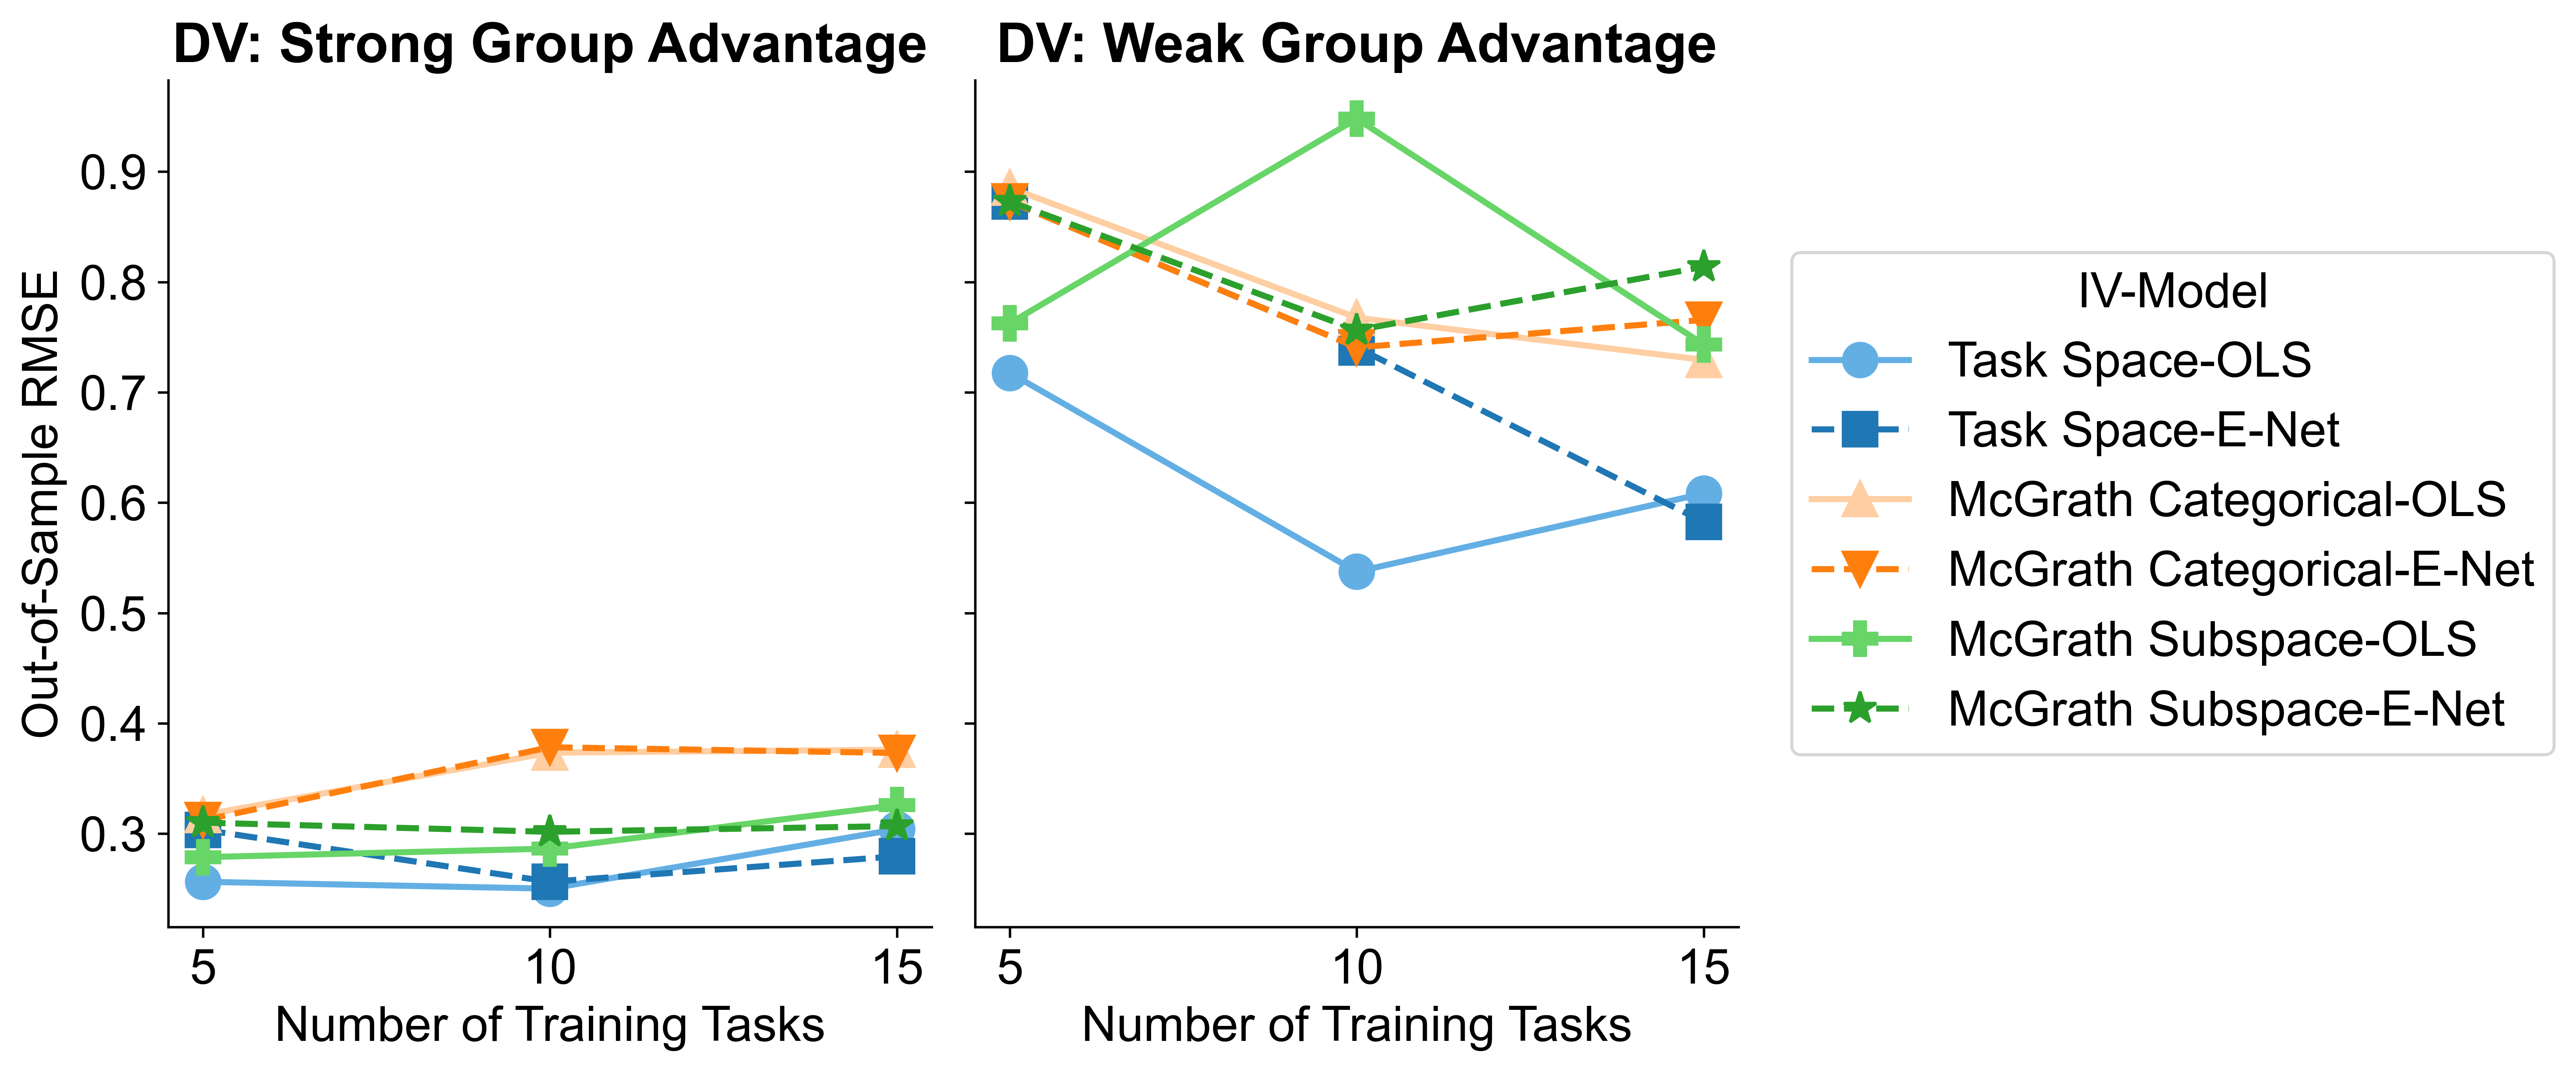

In [ ]:
plot_model_comparison(df_plot_rmse, ["Task Space", "McGrath Categorical", "McGrath Subspace"], "RMSE")

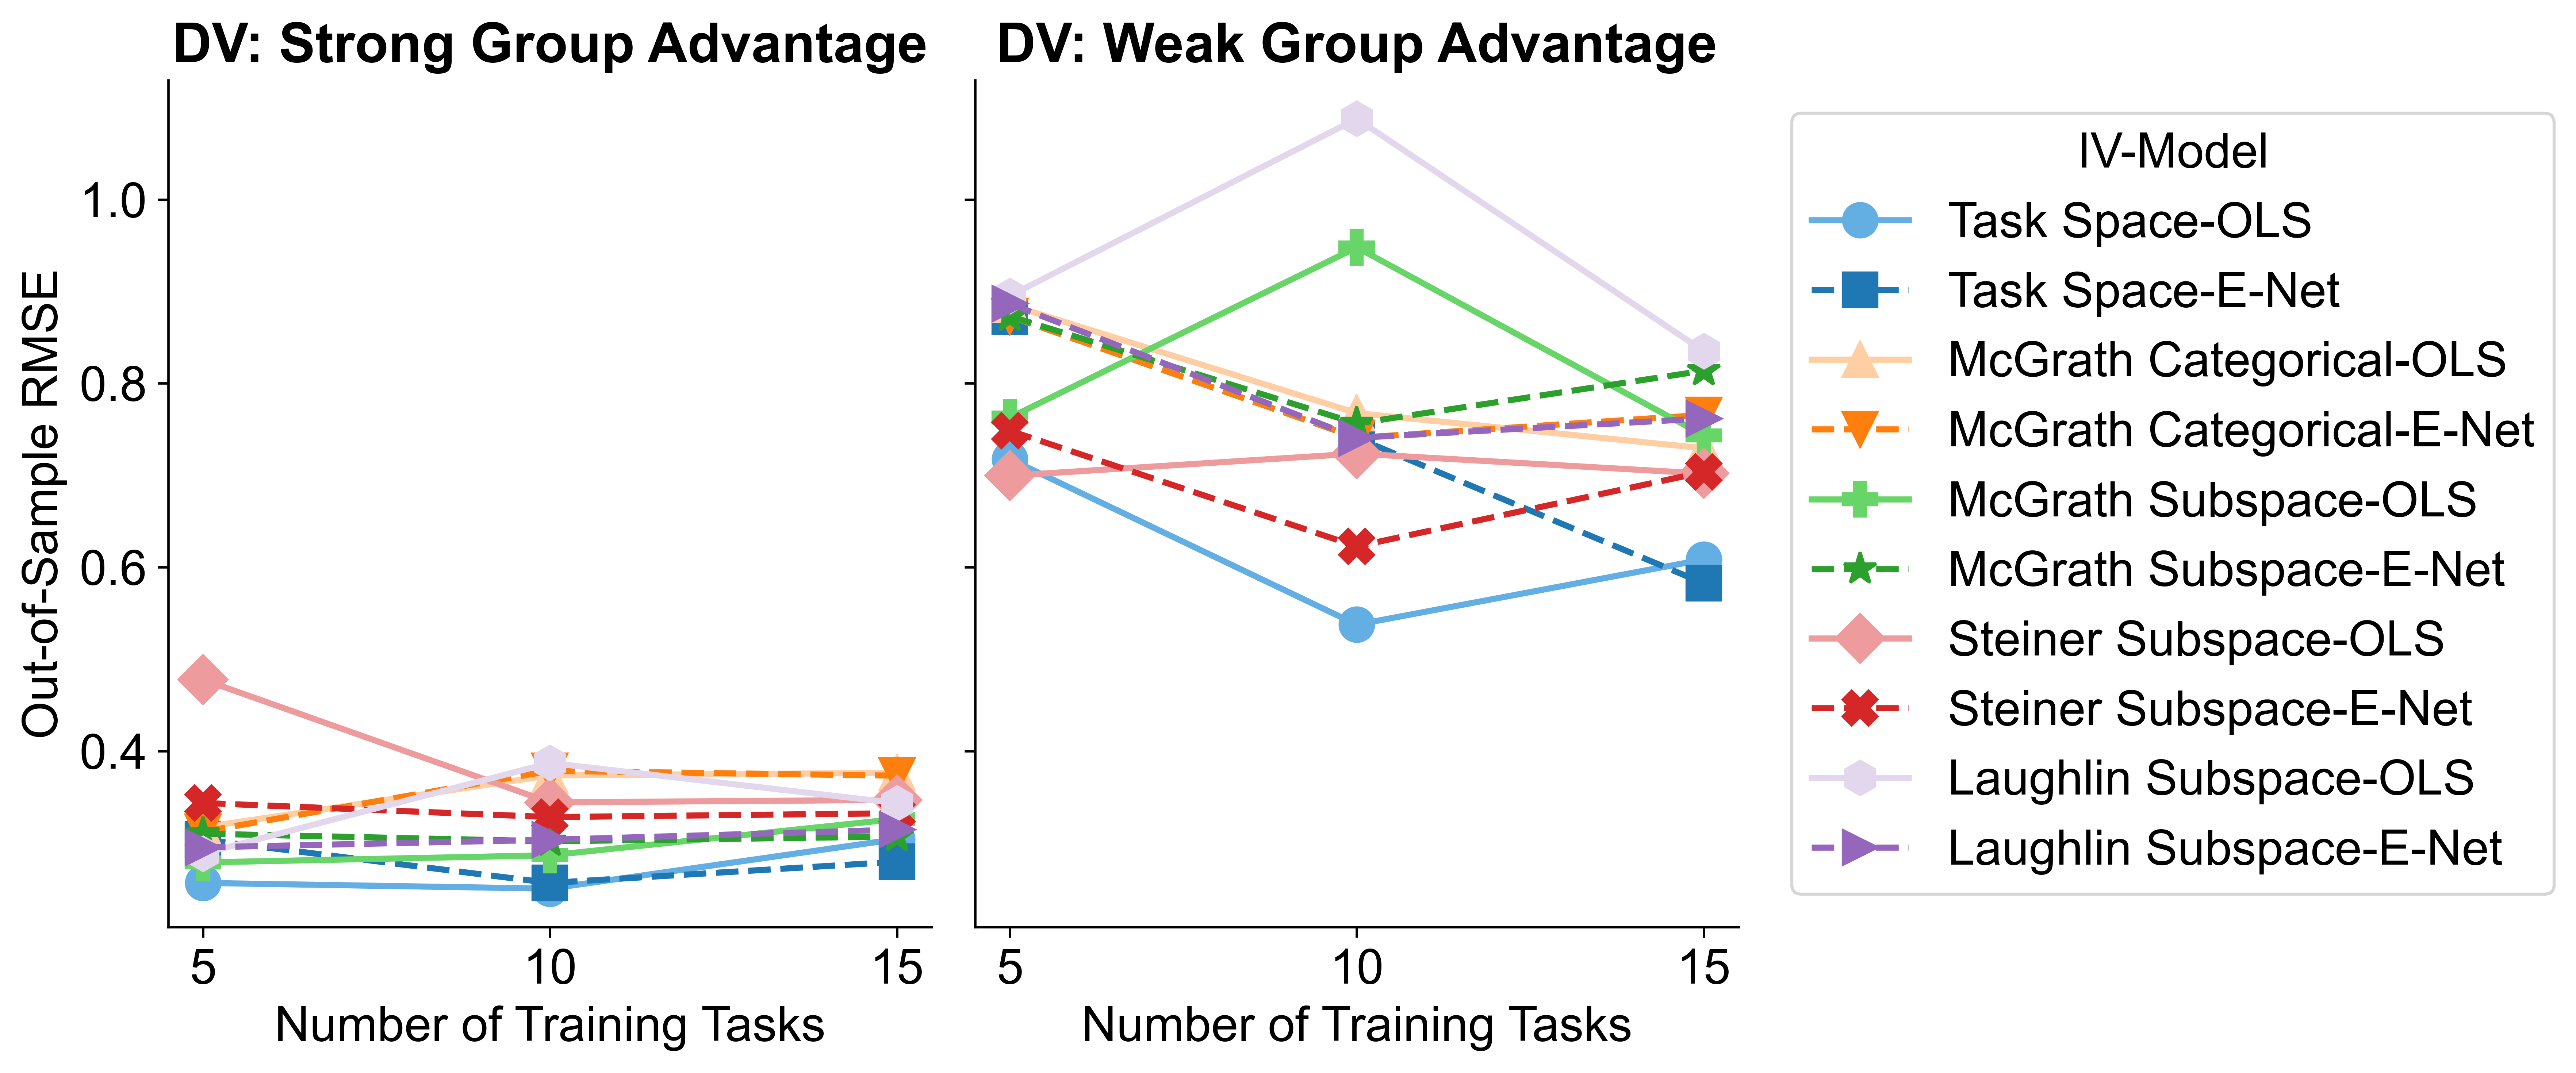

In [264]:
plot_model_comparison(df_plot_rmse, ["Task Space", "McGrath Categorical", "McGrath Subspace", "Steiner Subspace", "Laughlin Subspace"], "RMSE")

## R^2 Plots

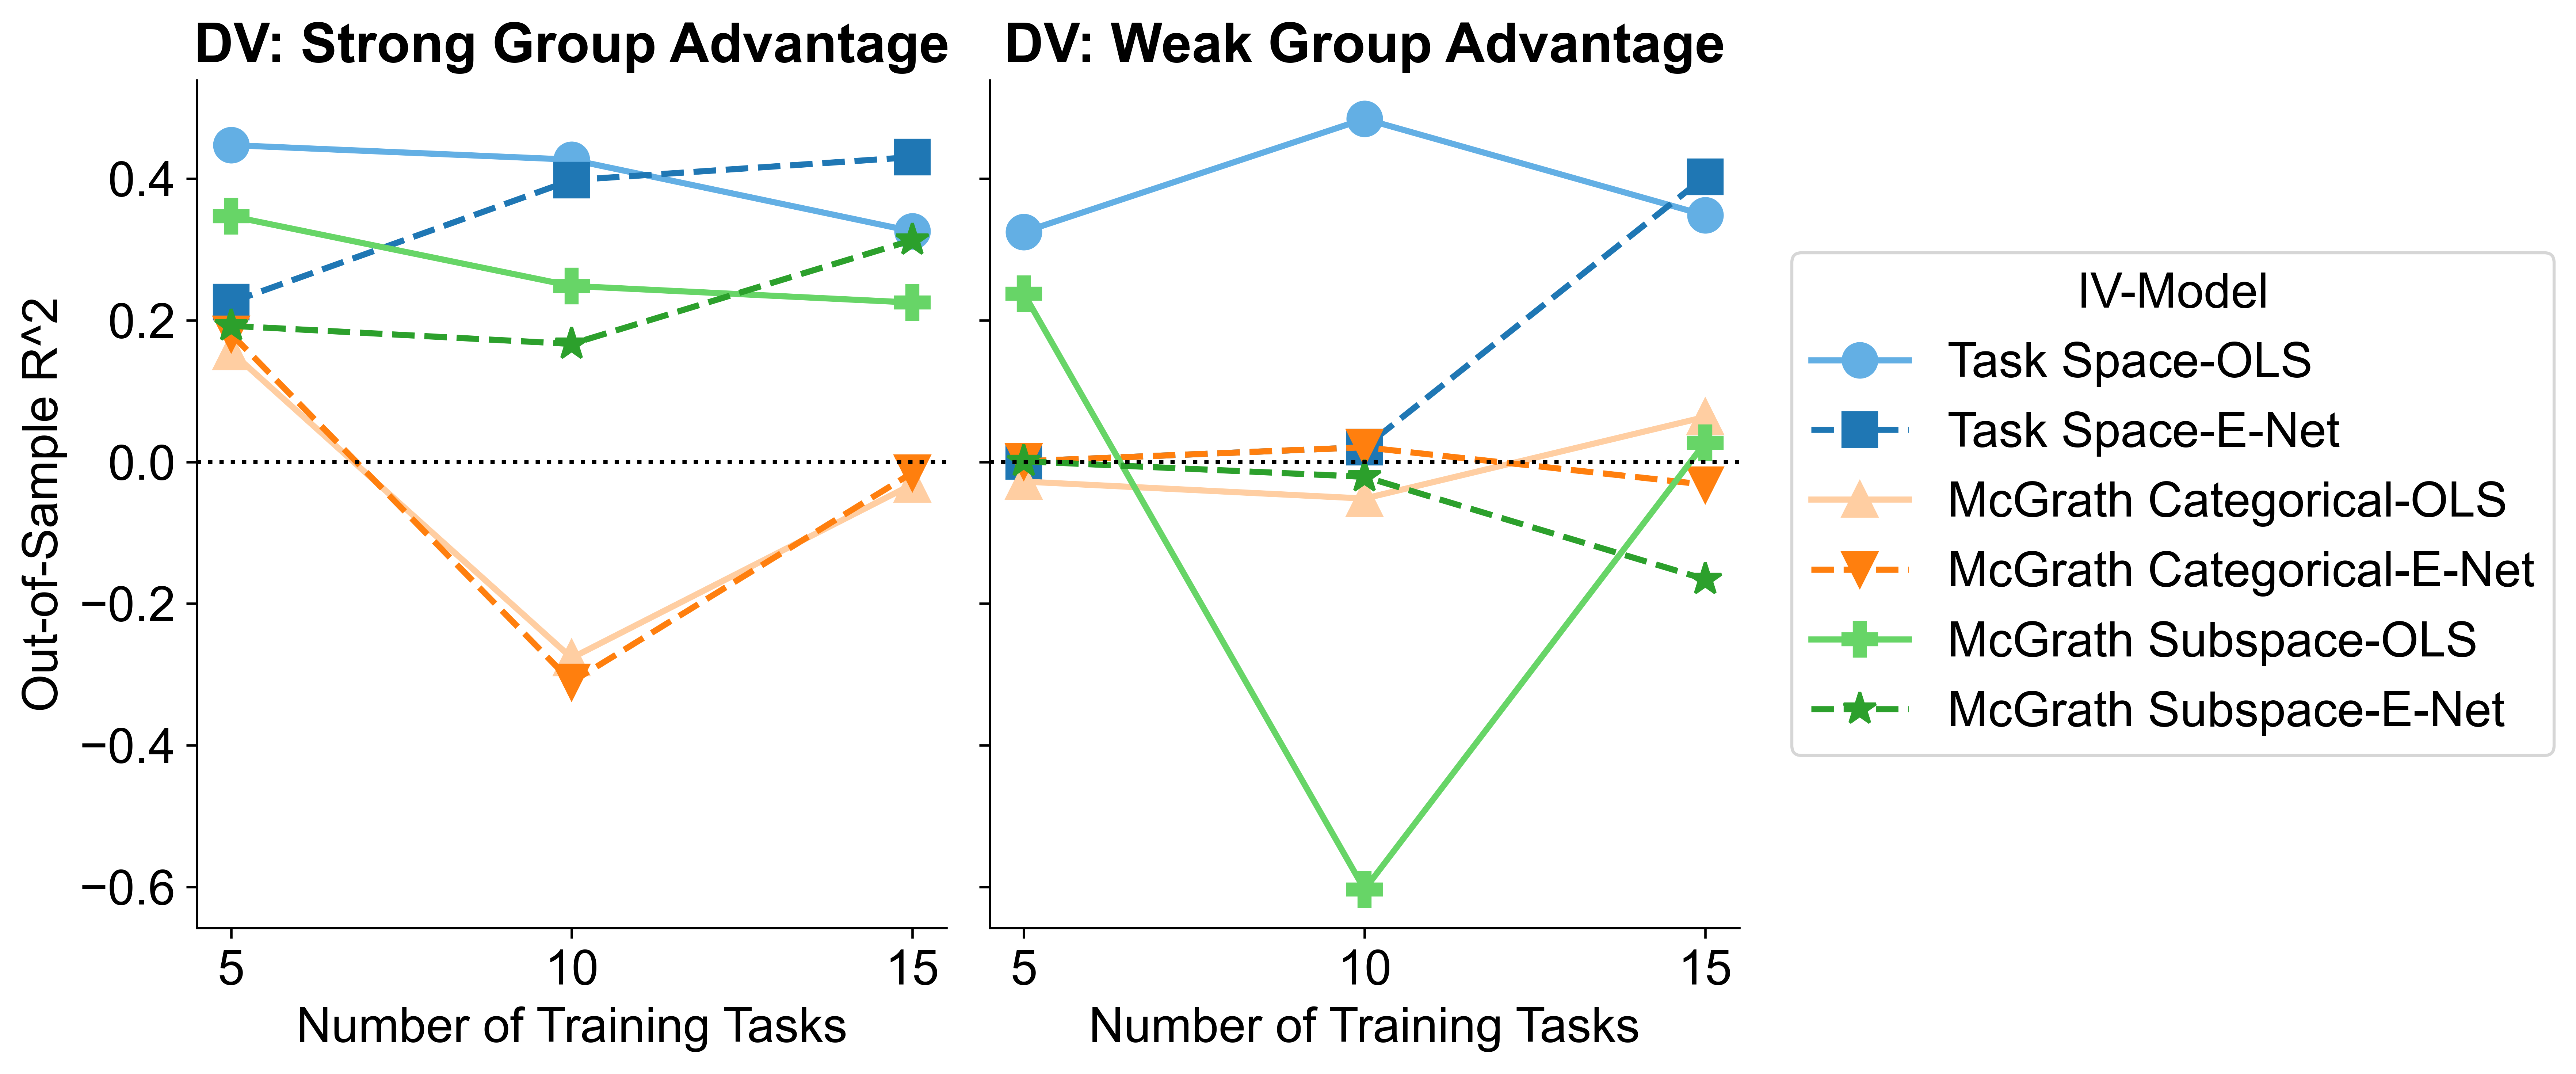

In [265]:
plot_model_comparison(df_plot_r2, ["Task Space", "McGrath Categorical", "McGrath Subspace"], "R^2")

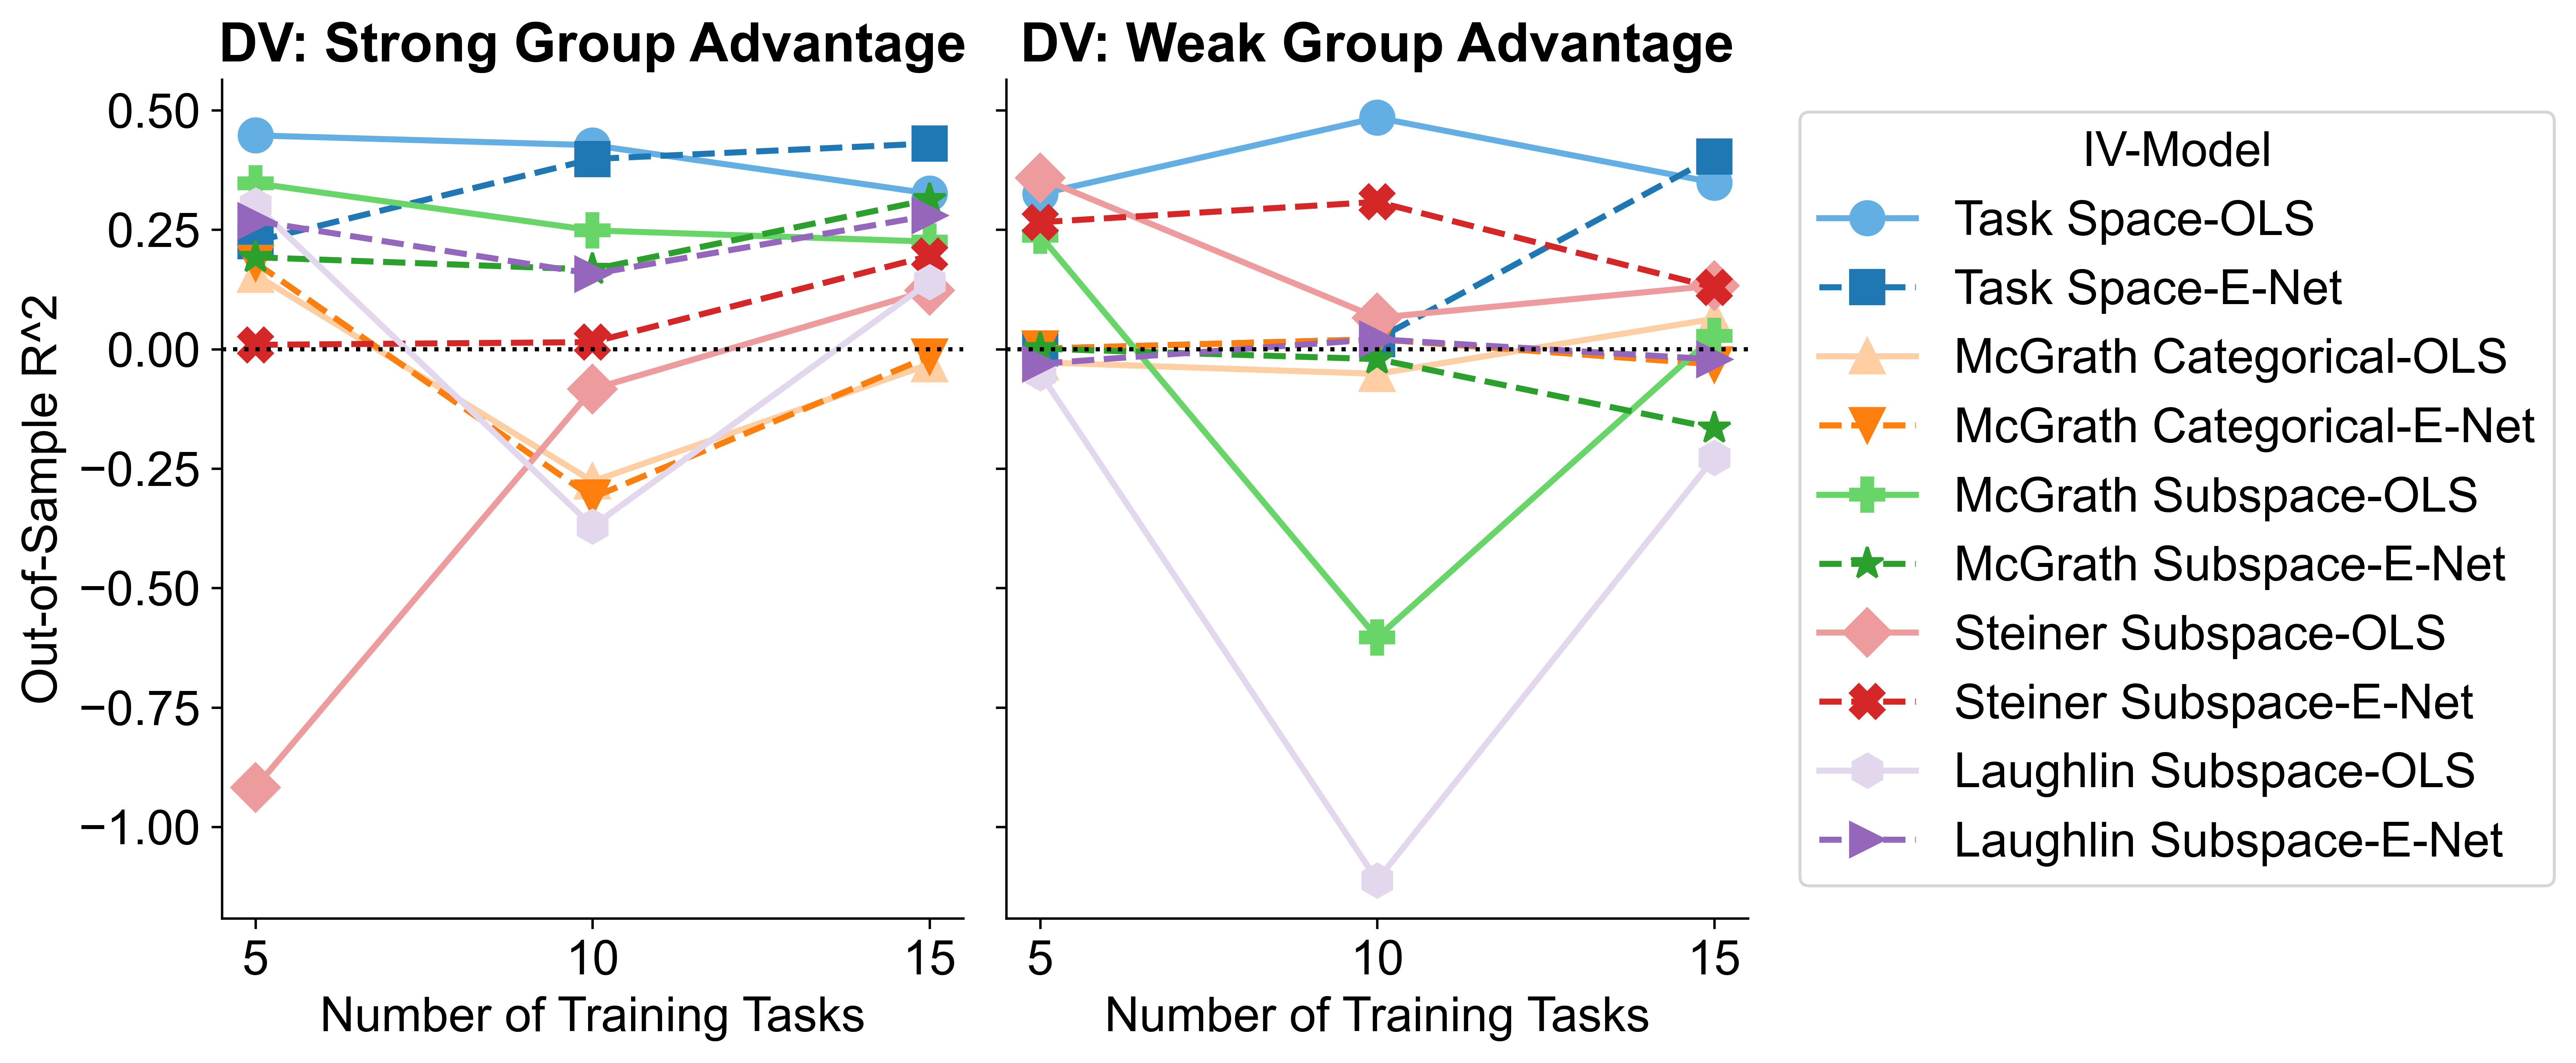

In [266]:
plot_model_comparison(df_plot_r2, ["Task Space", "McGrath Categorical", "McGrath Subspace", "Steiner Subspace", "Laughlin Subspace"], "R^2")

# Combined Figure 3

In [ ]:
# function for getting RMSE from a trained model
def get_rmse_for_ols_enet(model_ols, model_enet, X_test, y_true, ivs):
    """
    Calculate RMSE for the OLS and E-Net predictions.
    """
    rmse_ols = get_rmse_ols(model_ols, X_test, y_true, ivs)
    rmse_enet = get_rmse_for_enet(model_enet, X_test, y_true, ivs)
    
    return rmse_ols, rmse_enet

In [ ]:
def plot_group_advantage_pred_vs_obs_strong_weak(
    MODELS, wave, DATA, custom_r2, ivs_selected,
    get_rmse_ols, get_rmse_for_enet
):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import numpy as np
    import statsmodels.api as sm

    base_palette = {
        "Task Space":"#1f77b4","McGrath Categorical":"#ff7f0e","McGrath Subspace":"#2ca02c",
        "Steiner Subspace": "#d62728", "Laughlin Subspace": "#9467bd"
    }
    marker_dict = {
        "Task Space-OLS":"o","Task Space-E-Net":"s",
        "McGrath Categorical-OLS":"^","McGrath Categorical-E-Net":"v",
        "McGrath Subspace-OLS":"P","McGrath Subspace-E-Net":"X",
        "Steiner Subspace-OLS":"D", "Steiner Subspace-E-Net":"*",
        "Laughlin Subspace-OLS":"h", "Laughlin Subspace-E-Net":">"
    }
    fallback_color = "#888"
    fallback_marker = "o"
    models = ["OLS", "E-Net"]
    dvs = ["strong", "weak"]
    ms=90

    # Create subplots with 2 rows and 2*N columns (N = number of IVs selected)
    fig,axes=plt.subplots(2,len(ivs_selected)*2,figsize=(len(ivs_selected)*6,7))

    # Main plotting loop
    for r,dv in enumerate(dvs):
        for i,iv in enumerate(ivs_selected):
            if iv not in base_palette: base_palette[iv] = fallback_color
            if f"{iv}-OLS" not in marker_dict: marker_dict[f"{iv}-OLS"] = fallback_marker
            if f"{iv}-E-Net" not in marker_dict: marker_dict[f"{iv}-E-Net"] = fallback_marker

            # get correct ivs list
            if iv=="Task Space": ivs = basic_IVs
            elif iv=="McGrath Categorical": ivs = categorical_IVs
            elif iv=="McGrath Subspace": ivs = mcgrath_continuous
            elif iv=="Steiner Subspace": ivs = steiner_continuous
            elif iv=="Laughlin Subspace": ivs = laughlin_continuous
            else: raise ValueError(f"Unknown IV type: {iv}")

            m_ols = MODELS[iv]["OLS"][wave][dv]
            m_enet = MODELS[iv]["E-Net"][wave][dv]
            Xtest_all = DATA[wave]["test"]
            y = Xtest_all[dv].values
            ytr = DATA[wave]["train"][dv].mean()
            # Make X_test for each model
            X_ols = sm.add_constant(Xtest_all[ivs],has_constant='add')
            X_enet = add_interactions(Xtest_all[ivs])
            for j,m in enumerate(models):
                c = i*2+j
                ax = axes[r,c]
                mdl = m_ols if m=="OLS" else m_enet
                X = X_ols if m=="OLS" else X_enet
                try:
                    # Ensure X matches training columns!
                    if hasattr(mdl,"model") and hasattr(mdl.model,"exog_names"):
                        needed_cols = mdl.model.exog_names
                        X = X.reindex(columns=needed_cols, fill_value=0)
                    yhat = mdl.predict(X) if hasattr(mdl,'predict') else mdl(X)
                    if hasattr(yhat,'flatten'): yhat = yhat.flatten()
                except Exception as e:
                    ax.set_xticks([]); ax.set_yticks([]);
                    ax.set_facecolor("#F6F6F6")
                    continue

                rmse = get_rmse_ols(m_ols,Xtest_all,y,ivs) if m=="OLS" else get_rmse_for_enet(m_enet,Xtest_all,y,ivs)
                color=base_palette[iv]
                marker=marker_dict[f"{iv}-{m}"]

                ax.scatter(y,yhat,color=color,marker=marker,s=ms,edgecolor="k",alpha=.96)
                mi,ma=min(np.min(y),np.min(yhat)),max(np.max(y),np.max(yhat))
                ax.plot([mi,ma],[mi,ma],'k--',lw=1,alpha=.85)
                ax.axhline(ytr,color='#D90368',lw=2)
                ax.text(.045,.98,f"$R^2$={custom_r2(yhat,y,DATA[wave]['train'],DATA[wave]['test'],dv):.2f}\nRMSE={rmse:.2f}",
                        ha="left",va="top",transform=ax.transAxes,fontsize=17,fontweight="bold",
                        bbox=dict(facecolor="w",alpha=.72,boxstyle="round,pad=0.13"))
                ax.tick_params(axis="x",labelsize=13)
                ax.tick_params(axis="y",labelsize=13)
                [sp.set_visible(False) for sp in ax.spines.values()]
                ax.set_facecolor('white')

    # Side labels
    for row,dv in enumerate(dvs):
        p=axes[row,0].get_position();ym=p.y0+p.height/2
        fig.text(.0085,ym,f'DV: {"Strong" if dv=="strong" else "Weak"}',va="center",ha="right",rotation=90,fontsize=20,fontweight="bold")

    # Center group/IV and model labels
    buffer = 0.045 * (3/len(ivs_selected))  # Adjust buffer based on number of IVs
    left_offset = 0.02
    for i, iv in enumerate(ivs_selected):
        c0, c1 = i*2, i*2+1
        ax_l, ax_r = axes[0, c0], axes[0, c1]
        # Just add i*buffer, nothing else:
        xm_iv = (ax_l.get_position().x0 + ax_r.get_position().x1)/2 + i*buffer - left_offset
        fig.text(xm_iv, .975, f"{iv} IVs", ha="center", fontsize=19, fontweight="bold", color=base_palette[iv])
        x_l = (ax_l.get_position().x0 + ax_l.get_position().x1)/2 + i*buffer - left_offset
        x_r = (ax_r.get_position().x0 + ax_r.get_position().x1)/2 + i*buffer - left_offset
        fig.text(x_l, .93, "Linear Model",  color=base_palette[iv], fontsize=15, fontweight="bold", ha="center")
        fig.text(x_r, .93, "Elastic Net",   color=base_palette[iv], fontsize=15, fontweight="bold", ha="center")

    # Observed/Predicted labels
    fig.text(.047,.55,"Predicted",ha='center',va='center',rotation=90,fontsize=18,fontweight="bold")
    fig.text(.55,.08,"Observed",ha="center",va="center",fontsize=19,fontweight="bold")

    plt.subplots_adjust(wspace=0.35, hspace=0.25, right=0.99, top=0.92, left=0.095, bottom=0.18)

    le=[]
    for iv in ivs_selected:
        for m in models:
            le.append(Line2D([0],[0],marker=marker_dict[f"{iv}-{m}"],color=base_palette[iv],
                markerfacecolor=base_palette[iv],markeredgecolor='k',markersize=13,linestyle='None',label=f"{iv}-{m}"))
    le.append(Line2D([0],[0],color='k',label='1:1 Line',linestyle='--',lw=2))
    le.append(Line2D([0],[0],color='#D90368',label='Training Mean',linestyle='-',lw=3))

    fig.legend(handles=le,loc='lower center',fontsize=14,ncol=len(le)/2,bbox_to_anchor=(0.55,-.1),frameon=False)

    plt.savefig(f"../outputs/group_advantage_pred_vs_obs_{wave}_{len(ivs_selected)}_models.png",bbox_inches='tight',dpi=300)
    plt.savefig(f"../outputs/group_advantage_pred_vs_obs_{wave}_{len(ivs_selected)}_models.pdf",bbox_inches='tight',dpi=300)
    plt.show()

plot_group_advantage_pred_vs_obs_strong_weak(MODELS, "Wave 2", TRAIN_TEST_DATA, custom_r2,
                                             ["Task Space", "McGrath Subspace", "McGrath Categorical"], get_rmse_ols, get_rmse_for_enet)

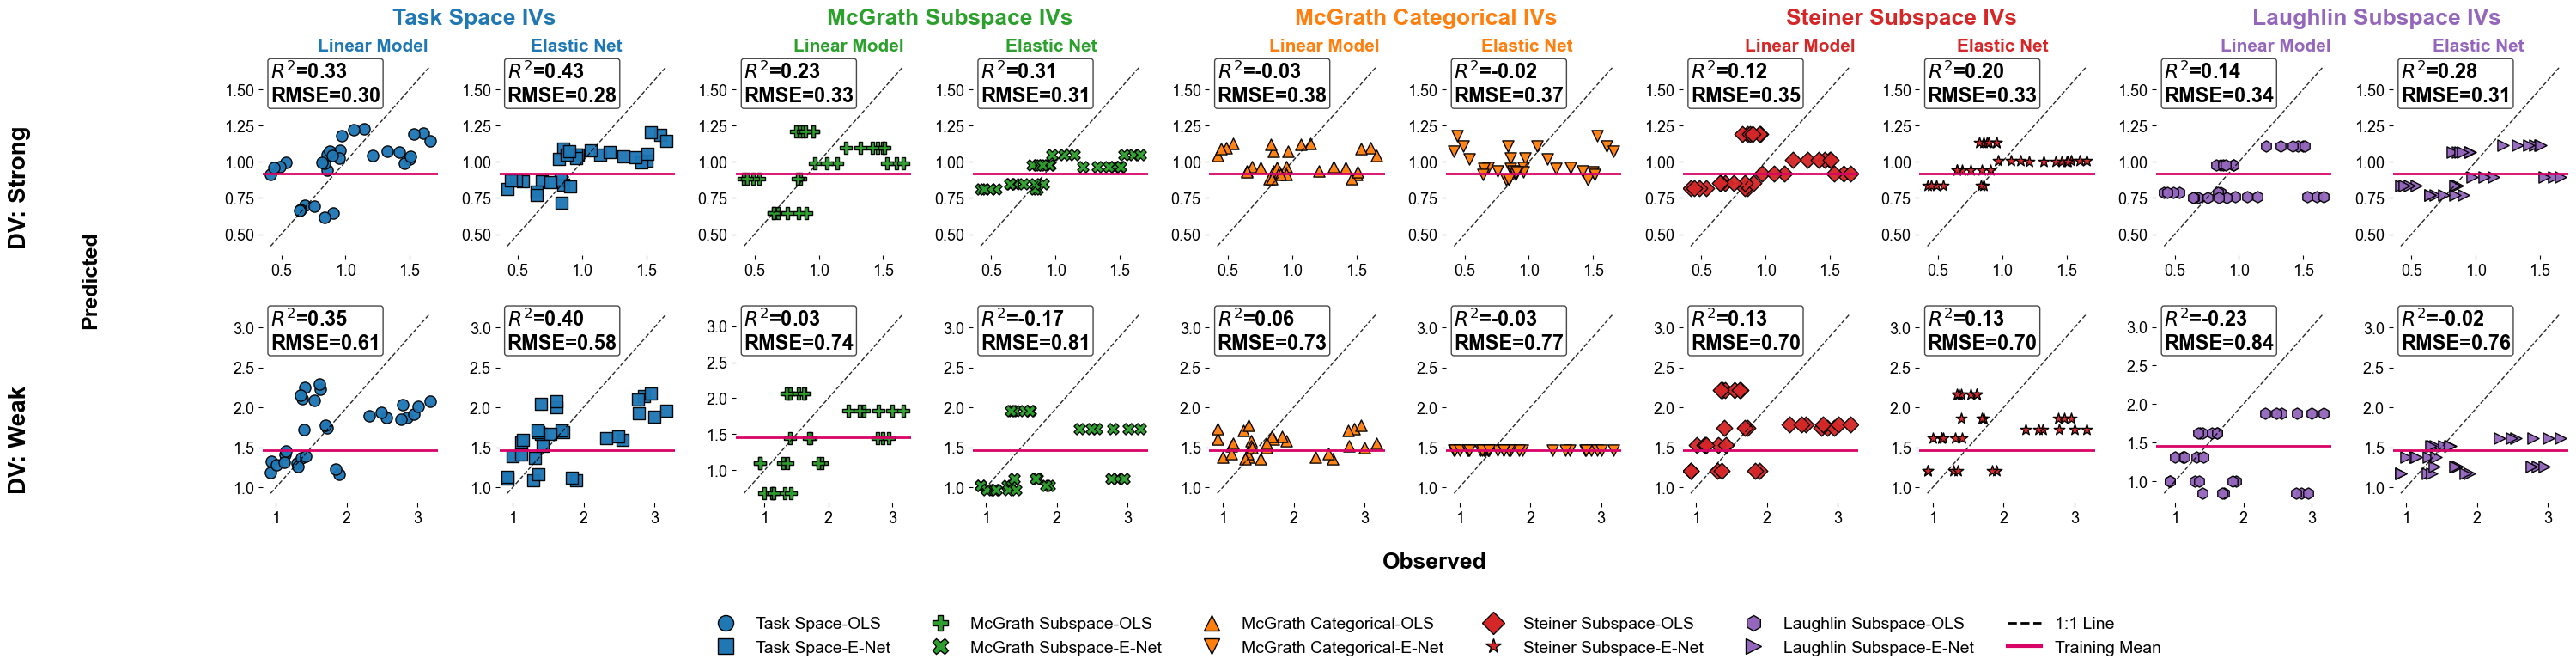

In [364]:
plot_group_advantage_pred_vs_obs_strong_weak(MODELS, "Wave 2", TRAIN_TEST_DATA, custom_r2,
                                             ["Task Space", "McGrath Subspace", "McGrath Categorical", "Steiner Subspace", "Laughlin Subspace"],
                                             get_rmse_ols, get_rmse_for_enet)

# R^2 p-value Comparisons

In [172]:
# try to read in BOOTSTRAP_R2_RESULTS if it exists, otherwise create it
bootstrap_r2_pkl_filename = '../outputs/bootstrap_r2_results.pkl'
bootstrap_model_pkl_filename = '../outputs/bootstrap_models.pkl'
bootstrap_rmse_pkl_filename = '../outputs/bootstrap_rmse_results.pkl'

try:
    with open(bootstrap_r2_pkl_filename, 'rb') as f:
        BOOTSTRAP_R2_RESULTS = pickle.load(f)
    with open(bootstrap_model_pkl_filename, 'rb') as f:
        BOOTSTRAP_MODELS = pickle.load(f)
    with open(bootstrap_rmse_pkl_filename, 'rb') as f:
        BOOTSTRAP_RMSE_RESULTS = pickle.load(f)
except FileNotFoundError:
    base_results_by_dv = {
            "OLS": {"strong": [], "weak": []},
            "E-Net": {"strong": [], "weak": []},
            "NN": {"strong": [], "weak": []}
        }

    BOOTSTRAP_R2_RESULTS = {
            "Task Space": copy.deepcopy(base_results_by_dv),
            "McGrath Categorical": copy.deepcopy(base_results_by_dv),
            "McGrath Subspace": copy.deepcopy(base_results_by_dv),
            "Steiner Subspace": copy.deepcopy(base_results_by_dv),
            "Laughlin Subspace": copy.deepcopy(base_results_by_dv)
        }
    BOOTSTRAP_MODELS = copy.deepcopy(BOOTSTRAP_R2_RESULTS)
    BOOTSTRAP_RMSE_RESULTS = copy.deepcopy(BOOTSTRAP_R2_RESULTS)

# all ways of choosing 5 tasks from df_condition_level_data
def get_all_combinations_of_tasks(df, num_tasks=5):
    """
    Get all combinations of tasks from the DataFrame.
    """
    tasks = df['task'].unique()
    return list(itertools.combinations(tasks, num_tasks))

# Sample a limited number of task combinations
all_held_out_options = get_all_combinations_of_tasks(df_condition_level_data, num_tasks=5)
random.seed(19104)
num_to_sample = 250
held_out_sample = random.sample(all_held_out_options, num_to_sample)

In [174]:
for i, held_out_set in enumerate(tqdm(held_out_sample, desc="Bootstrapping R2 Results", total=len(held_out_sample))):
    
    wave_a_data = df_condition_level_data[~df_condition_level_data["task"].isin(held_out_set)]
    wave_b_data = df_condition_level_data[df_condition_level_data["task"].isin(held_out_set)]

    for model_type in MODELS.keys():

        for dv_type in ["strong", "weak"]:
            if model_type == "Task Space":
                ivs = basic_IVs
            elif model_type == "McGrath Categorical":
                ivs = categorical_IVs
            elif model_type == "McGrath Subspace":
                ivs = mcgrath_continuous
            elif model_type == "Steiner Subspace":
                ivs = steiner_continuous
            elif model_type == "Laughlin Subspace":
                ivs = laughlin_continuous
            else:
                raise ValueError("Unknown model type: {}".format(model_type))
            

            # if the BOOTSTRAP_R2_RESULTS already has a model at this index, skip it
            try:
                model_ols = BOOTSTRAP_MODELS[model_type]["OLS"][dv_type][i]
                r2_ols = BOOTSTRAP_MODELS[model_type]["E-Net"][dv_type][i]
            except IndexError:
                
                # Train and test OLS model
                model_ols, r2_ols = train_wave_a_test_wave_b(
                    wave_a_data.copy(), wave_b_data.copy(), dv_type, ivs, f"{model_type} {dv_type} {held_out_set}", plot=False
                )
                # Train and test E-Net model
                model_enet, r2_enet = train_wave_a_test_wave_b_enet(
                    wave_a_data.copy(), wave_b_data.copy(), dv_type, ivs, f"{model_type} {dv_type} {held_out_set}", plot=False
                )

                # get model rmse on test set
                rmse_ols, rmse_enet = get_rmse_for_ols_enet(
                    model_ols, model_enet, wave_b_data, wave_b_data[dv_type], ivs
                )
                
                # store the models
                BOOTSTRAP_MODELS[model_type]["OLS"][dv_type].append(model_ols)
                BOOTSTRAP_MODELS[model_type]["E-Net"][dv_type].append(model_enet)

                # Store the R^2
                BOOTSTRAP_R2_RESULTS[model_type]["OLS"][dv_type].append(r2_ols)
                BOOTSTRAP_R2_RESULTS[model_type]["E-Net"][dv_type].append(r2_enet)

                # Store the RMSE
                BOOTSTRAP_RMSE_RESULTS[model_type]["OLS"][dv_type].append(rmse_ols)
                BOOTSTRAP_RMSE_RESULTS[model_type]["E-Net"][dv_type].append(rmse_enet)

                # write to pkl
                with open(bootstrap_model_pkl_filename, 'wb') as f:
                    pickle.dump(BOOTSTRAP_MODELS, f)
                with open(bootstrap_r2_pkl_filename, 'wb') as f:
                    pickle.dump(BOOTSTRAP_R2_RESULTS, f)
                with open(bootstrap_rmse_pkl_filename, 'wb') as f:
                    pickle.dump(BOOTSTRAP_RMSE_RESULTS, f)

Bootstrapping R2 Results:   0%|          | 0/250 [00:00<?, ?it/s]

Bootstrapping R2 Results: 100%|██████████| 250/250 [4:50:48<00:00, 69.80s/it]  


### Plot boxplot of R^2 Distributions

In [196]:
def analyze_bootstrap_r2_boxplot(bootstrapped_r2_results, plt_title, dv_choice, xlim_min = -5, xlim_max = 1.05, xlab = '$R^2$'):
    if dv_choice not in ['strong', 'weak']:
        raise ValueError("Invalid DV type. Please choose 'strong' or 'weak'.")

    plot_data = []
    for iv_type, models in bootstrapped_r2_results.items():
        for model_type, dv_types in models.items():
            r2_values = dv_types.get(dv_choice, [])
            if r2_values:
                for r2 in np.atleast_1d(r2_values):
                    plot_data.append({
                        'IV Type': iv_type,
                        'Model Type': f"{iv_type} - {model_type} - {dv_choice}",
                        'Model': model_type,
                        'R2': r2
                    })

    df_plot = pd.DataFrame(plot_data)

    color_dict = {}
    for iv in base_palette.keys():
        for model in ["OLS", "E-Net"]:
            for dv in ["strong", "weak"]:
                k = f"{iv} - {model} - {dv}"
                c = get_color(iv, model)
                color_dict[k] = c

    iv_order = list(reversed(list(base_palette.keys())))

    g = sns.FacetGrid(
        df_plot, 
        col="IV Type", 
        col_wrap=1, 
        sharex=False, 
        sharey=False, 
        height=3.6, 
        aspect=1.5, 
        margin_titles=True
    )

    g.map_dataframe(
        sns.boxplot,
        x="R2",
        y='Model',
        hue='Model Type',
        hue_order=df_plot['Model Type'].unique(),
        palette=color_dict,
        fliersize=2,
        linewidth=1,
        width=0.6,
        medianprops={'linewidth': 3} 
    )

    g.set_titles('{col_name}', size=16)
    g.set_axis_labels(xlab, '', fontsize=16)
    g.set(xlim=(xlim_min, xlim_max))
    g.despine(left=True)

    for ax in g.axes.flatten():
        ax.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

    g.fig.supylabel('Model', fontsize=20, x=0.02)

    plt.subplots_adjust(top=0.85, hspace=0.4)
    g.fig.set_size_inches(10, 15)
    g.fig.suptitle(f"{plt_title} {dv_choice.capitalize()} Group Advantage", fontsize=20, y=0.9, fontweight='bold')

    plt.savefig(f"../outputs/bootstrapped_r2_boxplot_{plt_title}_{dv_choice}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"../outputs/bootstrapped_r2_boxplot_{plt_title}_{dv_choice}.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    results = {}
    for model_type in ["OLS", "E-Net"]:
        results[model_type] = {}
        iv_types = list(bootstrapped_r2_results.keys())
        for i, iv_1 in enumerate(iv_types):
            if not bootstrapped_r2_results[iv_1][model_type].get(dv_choice, []):
                continue
            for iv_2 in iv_types[i+1:]:
                if not bootstrapped_r2_results[iv_2][model_type].get(dv_choice, []):
                    continue
                data1 = bootstrapped_r2_results[iv_1][model_type][dv_choice]
                data2 = bootstrapped_r2_results[iv_2][model_type][dv_choice]
                if data1 and data2:
                    t_stat, p_value = stats.ttest_ind(data1, data2, nan_policy='omit')
                    results[model_type][f"{iv_1} vs {iv_2} - {dv_choice}"] = (format_value(t_stat), format_p_value(p_value))

    for model_type, comparisons in results.items():
        print(f"\n{model_type}")
        for comparison, (t_statistic, p_value) in comparisons.items():
            direction = "up" if float(t_statistic) > 0 else "down"
            print(f"{comparison}: t-statistic = {t_statistic} ({direction}), p-value = {p_value}")

def format_value(value):
    if pd.isna(value) or value is None:
        return np.nan
    if abs(value) > 5:
        return np.format_float_scientific(value, precision=4)
    return np.round(value, 4)

def format_p_value(p_value):
    if pd.isna(p_value) or p_value is None:
        return np.nan
    if p_value < 0.001:
        return np.format_float_scientific(p_value, precision=4)
    return np.round(p_value, 4)

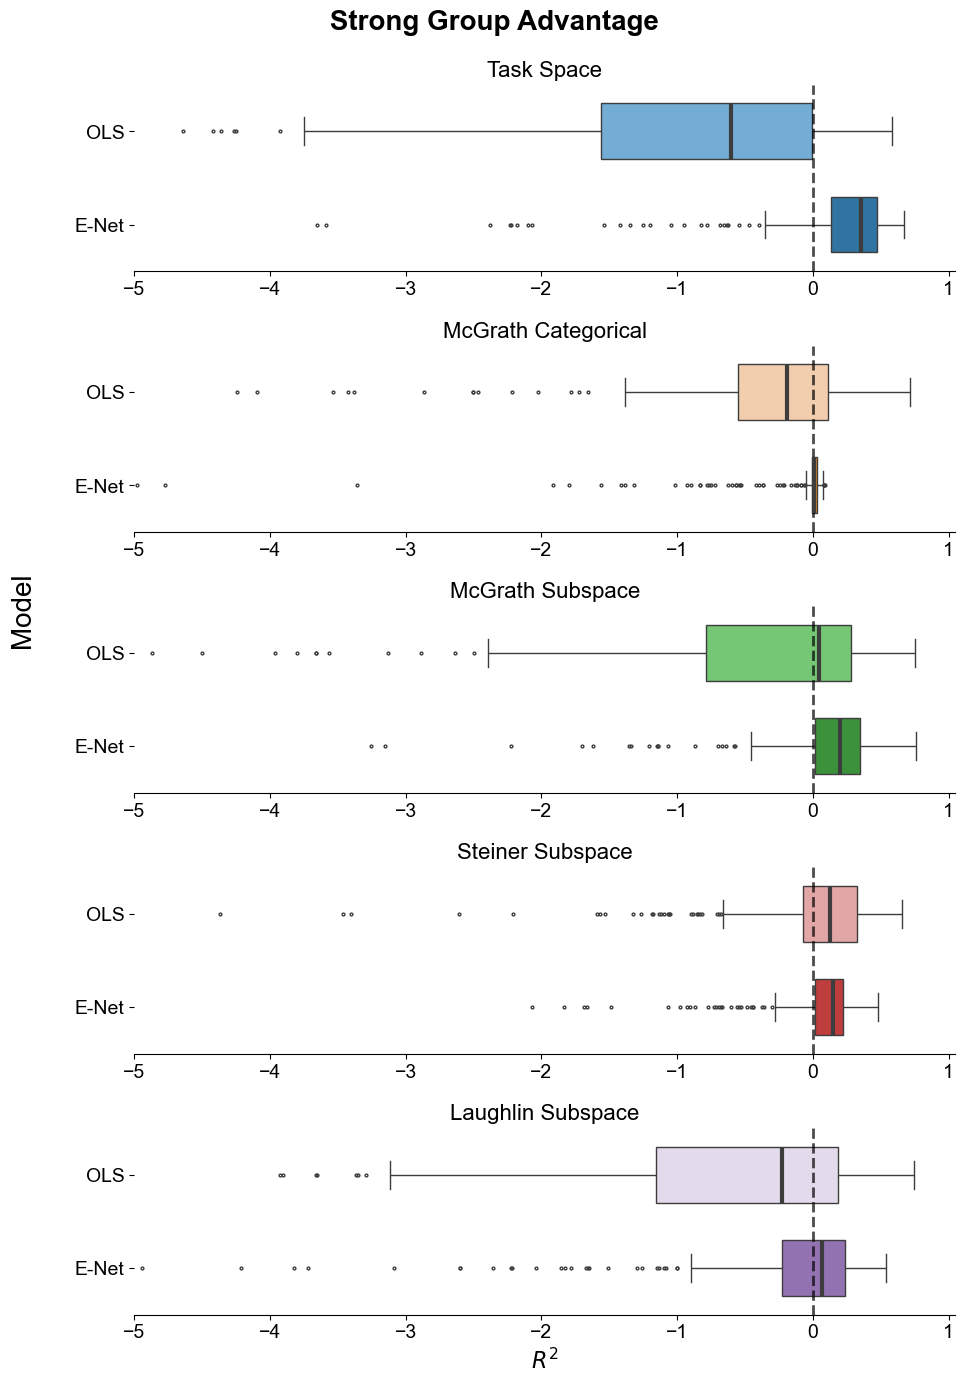


OLS
Task Space vs McGrath Categorical - strong: t-statistic = -5.5667e+00 (down), p-value = 4.2491e-08
Task Space vs McGrath Subspace - strong: t-statistic = -3.4098 (down), p-value = 7.0299e-04
Task Space vs Steiner Subspace - strong: t-statistic = -6.8872e+00 (down), p-value = 1.7221e-11
Task Space vs Laughlin Subspace - strong: t-statistic = -1.9214 (down), p-value = 0.0552
McGrath Categorical vs McGrath Subspace - strong: t-statistic = 2.2644 (up), p-value = 0.024
McGrath Categorical vs Steiner Subspace - strong: t-statistic = -3.6139 (down), p-value = 3.3225e-04
McGrath Categorical vs Laughlin Subspace - strong: t-statistic = 3.6063 (up), p-value = 3.4195e-04
McGrath Subspace vs Steiner Subspace - strong: t-statistic = -4.1924 (down), p-value = 3.2671e-05
McGrath Subspace vs Laughlin Subspace - strong: t-statistic = 1.4556 (up), p-value = 0.1461
Steiner Subspace vs Laughlin Subspace - strong: t-statistic = 5.1625e+00 (up), p-value = 3.5277e-07

E-Net
Task Space vs McGrath Categor

In [197]:
analyze_bootstrap_r2_boxplot(BOOTSTRAP_R2_RESULTS, "", "strong")

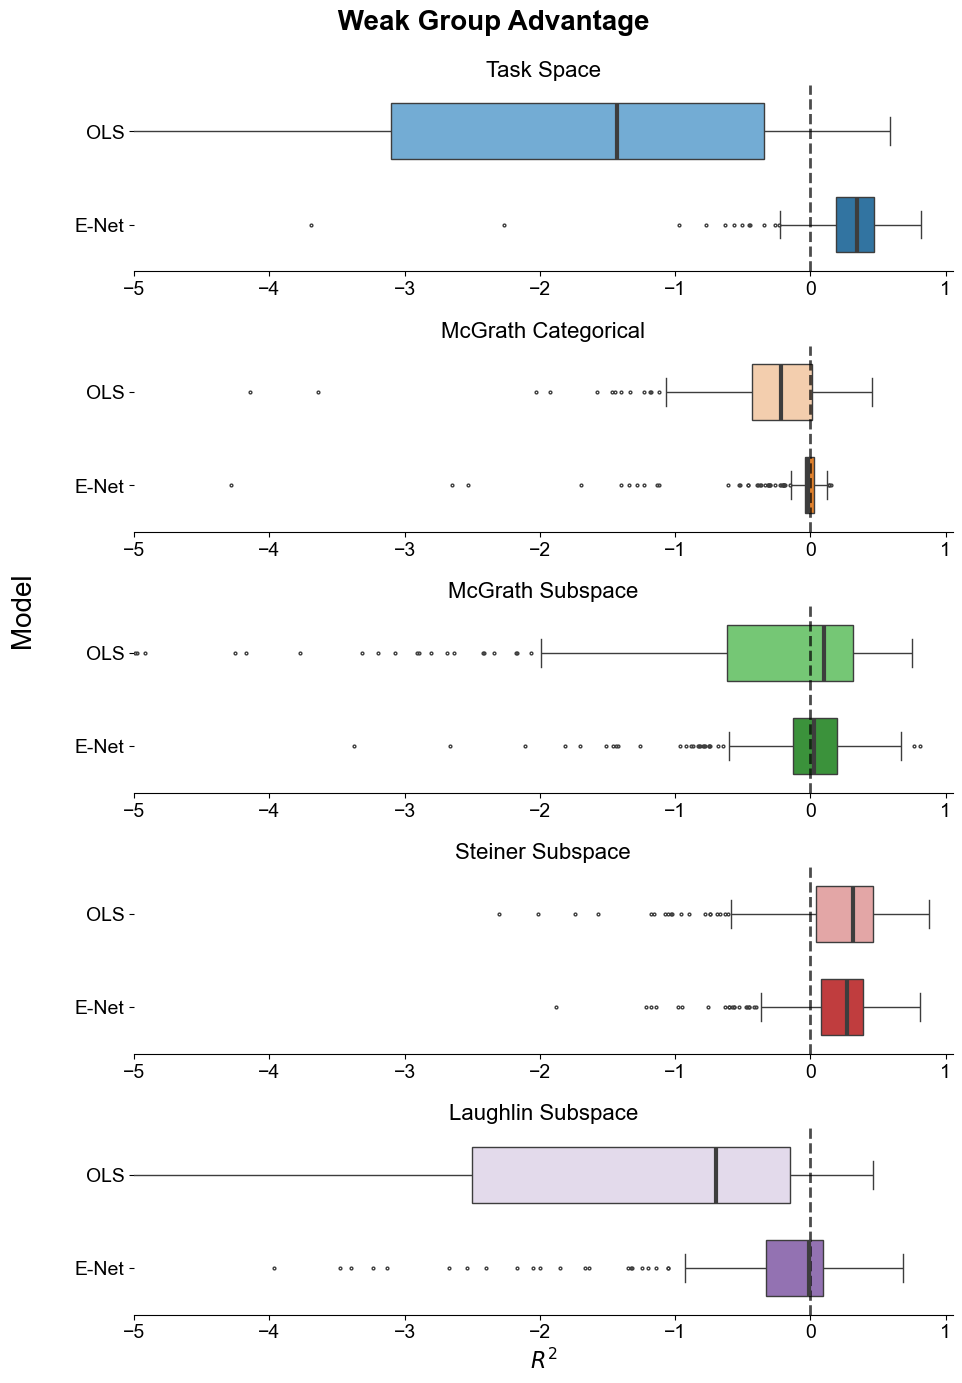


OLS
Task Space vs McGrath Categorical - weak: t-statistic = -1.0342e+01 (down), p-value = 7.7250e-23
Task Space vs McGrath Subspace - weak: t-statistic = -6.0388e+00 (down), p-value = 3.04e-09
Task Space vs Steiner Subspace - weak: t-statistic = -1.2668e+01 (down), p-value = 4.4827e-32
Task Space vs Laughlin Subspace - weak: t-statistic = 1.3322 (up), p-value = 0.1834
McGrath Categorical vs McGrath Subspace - weak: t-statistic = 2.784 (up), p-value = 0.0056
McGrath Categorical vs Steiner Subspace - weak: t-statistic = -1.0828e+01 (down), p-value = 1.1138e-24
McGrath Categorical vs Laughlin Subspace - weak: t-statistic = 7.5795e+00 (up), p-value = 1.7078e-13
McGrath Subspace vs Steiner Subspace - weak: t-statistic = -5.4404e+00 (down), p-value = 8.3483e-08
McGrath Subspace vs Laughlin Subspace - weak: t-statistic = 5.5197e+00 (up), p-value = 5.4730e-08
Steiner Subspace vs Laughlin Subspace - weak: t-statistic = 8.9355e+00 (up), p-value = 7.8890e-18

E-Net
Task Space vs McGrath Categori

In [198]:
analyze_bootstrap_r2_boxplot(BOOTSTRAP_R2_RESULTS, "", "weak")

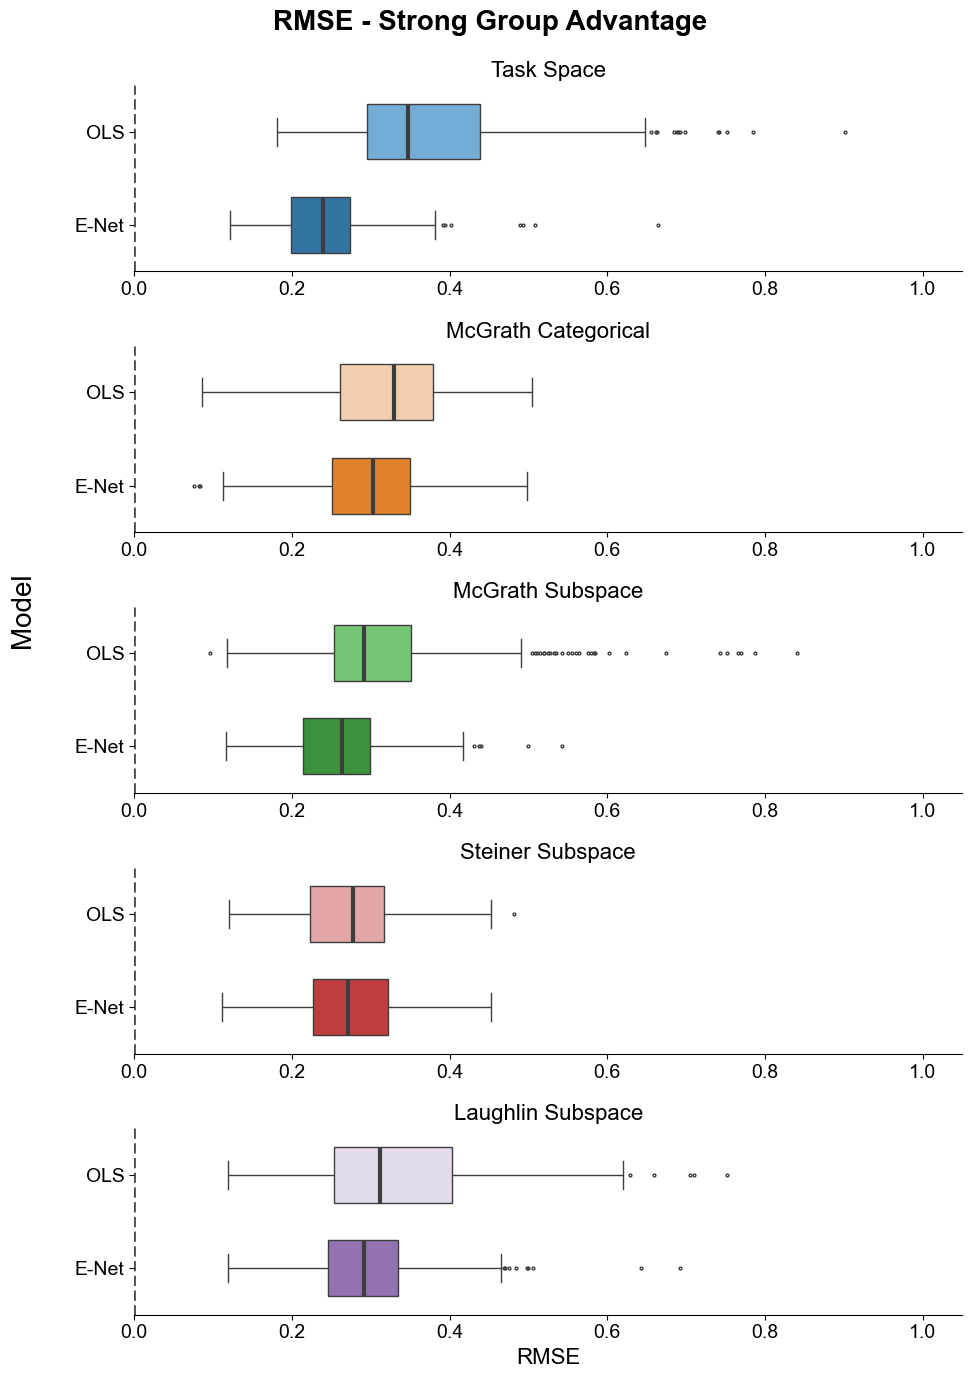


OLS
Task Space vs McGrath Categorical - strong: t-statistic = 6.6487e+00 (up), p-value = 7.7894e-11
Task Space vs McGrath Subspace - strong: t-statistic = 5.7241e+00 (up), p-value = 1.7989e-08
Task Space vs Steiner Subspace - strong: t-statistic = 1.2088e+01 (up), p-value = 1.1226e-29
Task Space vs Laughlin Subspace - strong: t-statistic = 4.0758 (up), p-value = 5.3371e-05
McGrath Categorical vs McGrath Subspace - strong: t-statistic = -0.0215 (down), p-value = 0.9829
McGrath Categorical vs Steiner Subspace - strong: t-statistic = 6.5457e+00 (up), p-value = 1.4754e-10
McGrath Categorical vs Laughlin Subspace - strong: t-statistic = -2.2605 (down), p-value = 0.0242
McGrath Subspace vs Steiner Subspace - strong: t-statistic = 5.1233e+00 (up), p-value = 4.3005e-07
McGrath Subspace vs Laughlin Subspace - strong: t-statistic = -1.8986 (down), p-value = 0.0582
Steiner Subspace vs Laughlin Subspace - strong: t-statistic = -7.8523e+00 (down), p-value = 2.5271e-14

E-Net
Task Space vs McGrath 

In [199]:
analyze_bootstrap_r2_boxplot(BOOTSTRAP_RMSE_RESULTS, "RMSE -", "strong", xlim_min=0, xlab = "RMSE")

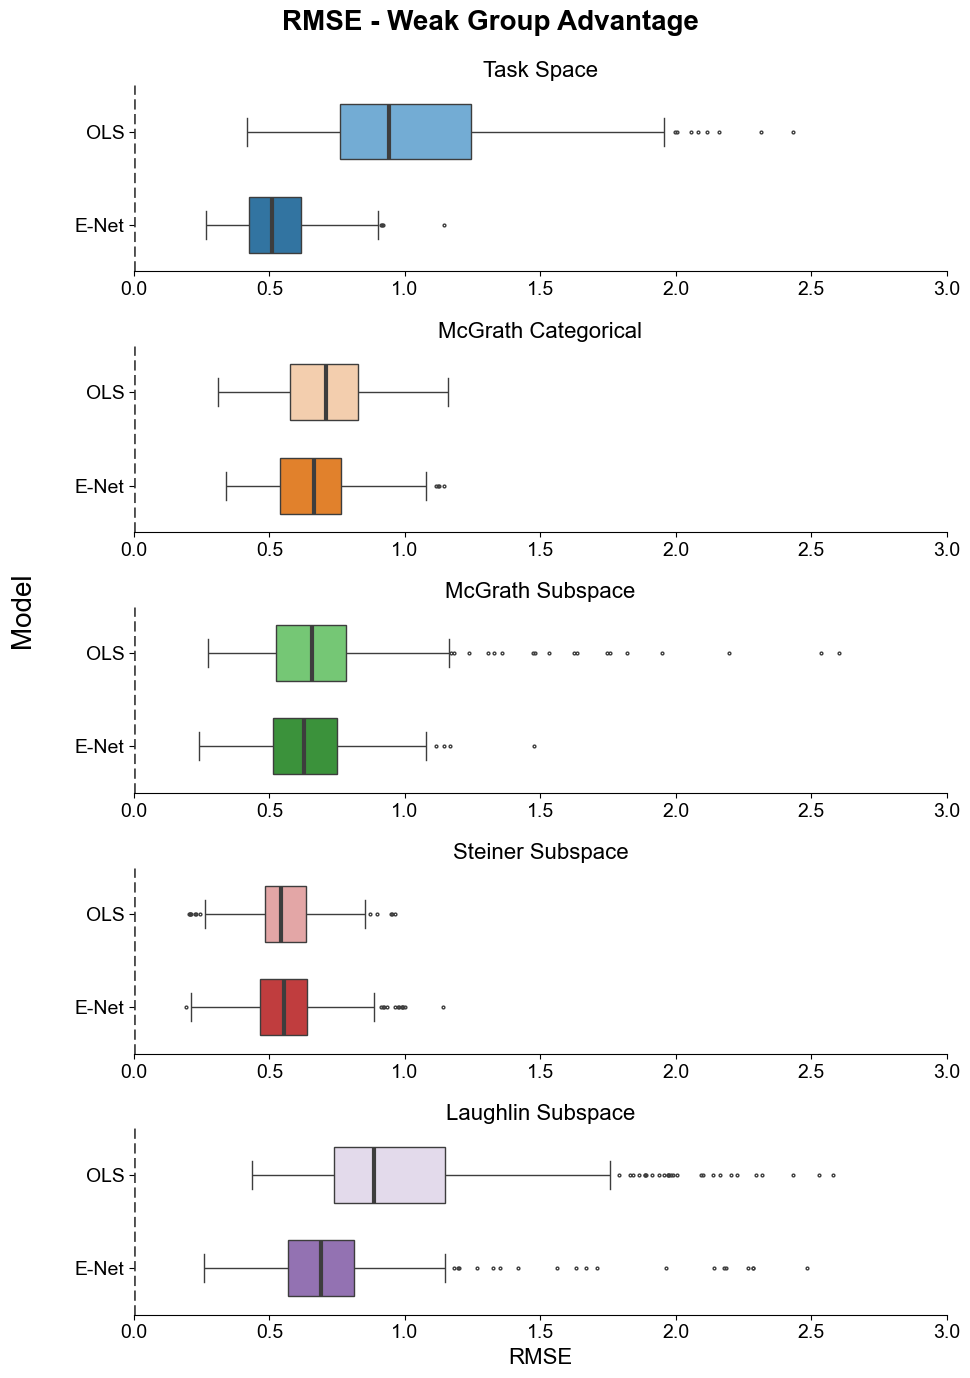


OLS
Task Space vs McGrath Categorical - weak: t-statistic = 1.2409e+01 (up), p-value = 5.3442e-31
Task Space vs McGrath Subspace - weak: t-statistic = 1.0247e+01 (up), p-value = 1.7365e-22
Task Space vs Steiner Subspace - weak: t-statistic = 1.9501e+01 (up), p-value = 2.3851e-63
Task Space vs Laughlin Subspace - weak: t-statistic = 0.3098 (up), p-value = 0.7569
McGrath Categorical vs McGrath Subspace - weak: t-statistic = 0.0388 (up), p-value = 0.9691
McGrath Categorical vs Steiner Subspace - weak: t-statistic = 1.2003e+01 (up), p-value = 2.4859e-29
McGrath Categorical vs Laughlin Subspace - weak: t-statistic = -1.0105e+01 (down), p-value = 5.8139e-22
McGrath Subspace vs Steiner Subspace - weak: t-statistic = 7.356e+00 (up), p-value = 7.8623e-13
McGrath Subspace vs Laughlin Subspace - weak: t-statistic = -8.7593e+00 (down), p-value = 3.0849e-17
Steiner Subspace vs Laughlin Subspace - weak: t-statistic = -1.593e+01 (down), p-value = 1.7966e-46

E-Net
Task Space vs McGrath Categorical -

In [200]:
analyze_bootstrap_r2_boxplot(BOOTSTRAP_RMSE_RESULTS, "RMSE -", "weak", xlim_min=0, xlim_max=3, xlab = "RMSE")

In [179]:
def calculate_pairwise_differences(data1, data2):
    differences = np.array(data1) - np.array(data2)
    mean_diff = np.mean(differences)
    
    # 1.96 method for confidence intervals
    sem_diff = np.std(differences, ddof=1) / np.sqrt(len(differences))
    ci_1_96_lower_diff = mean_diff - 1.96 * sem_diff
    ci_1_96_upper_diff = mean_diff + 1.96 * sem_diff
    
    # Percentile method
    ci_percentile_lower_diff = np.percentile(differences, 2.5)
    ci_percentile_upper_diff = np.percentile(differences, 97.5)
    
    return mean_diff, ci_1_96_lower_diff, ci_1_96_upper_diff, ci_percentile_lower_diff, ci_percentile_upper_diff

def generate_pairwise_summary_table(bootstrapped_r2_results, dv_choice):
    summary_data = []

    for model_type in ["OLS", "E-Net"]:
        iv_types = list(bootstrapped_r2_results.keys())
        for i, iv_1 in enumerate(iv_types):
            if not bootstrapped_r2_results[iv_1][model_type].get(dv_choice, []):
                continue
            for iv_2 in iv_types[i+1:]:
                if not bootstrapped_r2_results[iv_2][model_type].get(dv_choice, []):
                    continue
                data1 = bootstrapped_r2_results[iv_1][model_type][dv_choice]
                data2 = bootstrapped_r2_results[iv_2][model_type][dv_choice]
                if data1 and data2:
                    (mean_diff, ci_1_96_lower_diff, ci_1_96_upper_diff,
                     ci_percentile_lower_diff, ci_percentile_upper_diff) = calculate_pairwise_differences(data1, data2)

                    comparison_name = f"{iv_1} - {iv_2}"
                    summary_data.append({
                        'Model Type': model_type,
                        'Comparison': comparison_name,
                        'Mean Diff': mean_diff,
                        'CI 1.96 Lower': ci_1_96_lower_diff,
                        'CI 1.96 Upper': ci_1_96_upper_diff,
                        'CI Percentile Lower': ci_percentile_lower_diff,
                        'CI Percentile Upper': ci_percentile_upper_diff
                    })

    df_summary = pd.DataFrame(summary_data)
    df_summary.sort_values(by='Mean Diff', ascending=False, inplace=True)
    return df_summary

# Generate and print tables for both 'strong' and 'weak' DV types
pairwise_table_strong = generate_pairwise_summary_table(BOOTSTRAP_R2_RESULTS, 'strong')
pairwise_table_weak = generate_pairwise_summary_table(BOOTSTRAP_R2_RESULTS, 'weak')

print("Pairwise R^2 Summary Table - Strong Group Advantage")
print(pairwise_table_strong.to_string(index=False))
print("\nPairwise R^2 Summary Table - Weak Group Advantage")
print(pairwise_table_weak.to_string(index=False))

Pairwise R^2 Summary Table - Strong Group Advantage
Model Type                              Comparison  Mean Diff  CI 1.96 Lower  CI 1.96 Upper  CI Percentile Lower  CI Percentile Upper
       OLS    Steiner Subspace - Laughlin Subspace   0.880025       0.610838       1.149213            -1.040674             6.424184
       OLS McGrath Categorical - Laughlin Subspace   0.594351       0.287168       0.901533            -1.629087             6.678593
     E-Net          Task Space - Laughlin Subspace   0.435271       0.294631       0.575911            -0.842967             2.653544
     E-Net    McGrath Subspace - Laughlin Subspace   0.380652       0.232142       0.529162            -0.479853             2.504721
       OLS  McGrath Categorical - McGrath Subspace   0.301353       0.047260       0.555447            -1.911192             7.156368
     E-Net    Steiner Subspace - Laughlin Subspace   0.299934       0.146444       0.453425            -0.920730             2.590392
       OLS

In [181]:
# Generate and print tables for both 'strong' and 'weak' DV types
pairwise_table_strong_rmse = generate_pairwise_summary_table(BOOTSTRAP_RMSE_RESULTS, 'strong')
pairwise_table_weak_rmse = generate_pairwise_summary_table(BOOTSTRAP_RMSE_RESULTS, 'weak')

print("Pairwise RMSE Summary Table - Strong Group Advantage")
print(pairwise_table_strong_rmse.to_string(index=False))
print("\nPairwise RMSE Summary Table - Weak Group Advantage")
print(pairwise_table_weak_rmse.to_string(index=False))

Pairwise RMSE Summary Table - Strong Group Advantage
Model Type                              Comparison  Mean Diff  CI 1.96 Lower  CI 1.96 Upper  CI Percentile Lower  CI Percentile Upper
       OLS           Task Space - Steiner Subspace   0.109168       0.093162       0.125174            -0.073827             0.415752
       OLS        Task Space - McGrath Categorical   0.063681       0.047049       0.080312            -0.146280             0.393367
       OLS           Task Space - McGrath Subspace   0.063477       0.045601       0.081354            -0.232506             0.386947
       OLS     McGrath Subspace - Steiner Subspace   0.045691       0.029779       0.061603            -0.143057             0.412425
       OLS  McGrath Categorical - Steiner Subspace   0.045487       0.035575       0.055399            -0.103736             0.198898
       OLS          Task Space - Laughlin Subspace   0.043429       0.023791       0.063066            -0.278713             0.359387
     E-Ne

# Permutation and SHAP

Note: main text is not clear about which model(s) we're doing the SHAP analysis for...

In [34]:
# Define Task Space Groups
pretty_feature_cluster_names = {
    "['Type 2 (Generate)', 'Creativity Input']": "Creative",
    "['Type 3 and Type 4 (Objective Correctness)', 'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution', 'Answer Recognizability', 'Time Solvability', 'Intellective-Judgmental']": "Demonstrably Correct Answer",
    "['Conceptual-Behavioral', 'Intellectual-Manipulative']": "Physical",
    "Type 1 (Planning)": "Type 1 (Planning)",
    "Type 5 (Cognitive Conflict)": "Type 5 (Cognitive Conflict)",
    "Type 6 (Mixed-Motive)": "Type 6 (Mixed-Motive)",
    "Type 7 (Battle)": "Type 7 (Battle)",
    "Type 8 (Performance)": "Type 8 (Performance)",
    "Divisible-Unitary": "Divisible-Unitary",
    "Maximizing": "Maximizing",
    "Optimizing": "Optimizing",
    "Outcome Multiplicity": "Outcome Multiplicity",
    "Solution Scheme Multiplicity": "Solution Scheme Multiplicity",
    "Conflicting Tradeoffs": "Conflicting Tradeoffs",
    "Solution Scheme Outcome Uncertainty": "Solution Scheme Outcome Uncertainty",
    "Eureka Question": "Eureka Question"
}

Show relationships between clusters

In [35]:
df_condition_level_data[['Type 2 (Generate)', 'Creativity Input']].corr()

Type 2 (Generate)  Creativity Input
Type 2 (Generate)           1.000000          0.829328
Creativity Input            0.829328          1.000000

In [36]:
df_condition_level_data[['Type 3 and Type 4 (Objective Correctness)', 'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution', 'Answer Recognizability', 'Time Solvability', 'Intellective-Judgmental']].corr()

Type 3 and Type 4 (Objective Correctness)  \
Type 3 and Type 4 (Objective Correctness)                                   1.000000   
Decision Verifiability                                                      0.967066   
Shared Knowledge                                                            0.928585   
Within-System Solution                                                      0.654567   
Answer Recognizability                                                      0.959369   
Time Solvability                                                            0.975959   
Intellective-Judgmental                                                     0.982612   

                                           Decision Verifiability  \
Type 3 and Type 4 (Objective Correctness)                0.967066   
Decision Verifiability                                   1.000000   
Shared Knowledge                                         0.908816   
Within-System Solution                                   0.682047   
Answer Recognizability                                   0.972943   
Time Solvability                                         0.973843   
Intellective-Judgmental                                  0.945500   

                                           Shared Knowledge  \
Type 3 and Type 4 (Objective Correctness)          0.928585   
Decision Verifiability                             0.908816   
Shared Knowledge                                   1.000000   
Within-System Solution                             0.611842   
Answer Recognizability                             0.915565   
Time Solvability                                   0.933360   
Intellective-Judgmental                            0.961674   

                                           Within-System Solution  \
Type 3 and Type 4 (Objective Correctness)                0.654567   
Decision Verifiability                                   0.682047   
Shared Knowledge                                         0.611842   
Within-System Solution                                   1.000000   
Answer Recognizability                                   0.721279   
Time Solvability                                         0.698743   
Intellective-Judgmental                                  0.598344   

                                           Answer Recognizability  \
Type 3 and Type 4 (Objective Correctness)                0.959369   
Decision Verifiability                                   0.972943   
Shared Knowledge                                         0.915565   
Within-System Solution                                   0.721279   
Answer Recognizability                                   1.000000   
Time Solvability                                         0.962793   
Intellective-Judgmental                                  0.946780   

                                           Time Solvability  \
Type 3 and Type 4 (Objective Correctness)          0.975959   
Decision Verifiability                             0.973843   
Shared Knowledge                                   0.933360   
Within-System Solution                             0.698743   
Answer Recognizability                             0.962793   
Time Solvability                                   1.000000   
Intellective-Judgmental                            0.959235   

                                           Intellective-Judgmental  
Type 3 and Type 4 (Objective Correctness)                 0.982612  
Decision Verifiability                                    0.945500  
Shared Knowledge                                          0.961674  
Within-System Solution                                    0.598344  
Answer Recognizability                                    0.946780  
Time Solvability                                          0.959235  
Intellective-Judgmental                                   1.000000

In [37]:
df_condition_level_data[['Conceptual-Behavioral', 'Intellectual-Manipulative']].corr()

Conceptual-Behavioral  Intellectual-Manipulative
Conceptual-Behavioral                   1.000000                   0.974784
Intellectual-Manipulative               0.974784                   1.000000

In [38]:
def model_predict(fitted_model, X, model_type):
    if model_type == "LM":
        X = sm.add_constant(X, has_constant='add')
        return fitted_model.predict(X)
    elif model_type == "NN":
        return fitted_model.predict(X).flatten()
    elif model_type == "E-Net":
        X = add_interactions(X)
        return fitted_model.predict(X)

In [39]:
def plot_combined_feature_importance(
    model, wave_a_data, wave_b_data, ivs, dv_type, model_type, 
    save_path='./visualizations/combined_importance.png', n_repeats=100):
    
    set_random_seeds()

    X_test = wave_b_data[ivs].copy()
    y_test = wave_b_data[dv_type].values
    y_pred = model_predict(model, X_test, model_type)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Map features to their groups using the provided dictionary
    feature_to_group = {}
    for key, group_name in pretty_feature_cluster_names.items():
        try:
            feature_list = ast.literal_eval(key)
            features = feature_list if isinstance(feature_list, list) else [feature_list]
        except (ValueError, SyntaxError):
            features = [key]
        for feature in features:
            feature_to_group[feature] = group_name

    # Create a mapping from groups to features
    group_to_features = {}
    for feature in ivs:
        group_name = feature_to_group.get(feature, feature)
        group_to_features.setdefault(group_name, []).append(feature)
        feature_to_group[feature] = group_name

    groups = list(group_to_features.keys())
    importances = np.zeros(len(groups))
    conf_intervals = np.zeros(len(groups))

    # Calculate permutation feature importance for each group
    for i, group_name in enumerate(groups):
        features_in_group = group_to_features[group_name]
        scores = np.zeros(n_repeats)
        for n in range(n_repeats):
            X_permuted = X_test.copy()
            permutation = np.random.permutation(len(X_test))
            for feature in features_in_group:
                X_permuted[feature] = X_permuted[feature].values[permutation]
            y_permuted_pred = model_predict(model, X_permuted, model_type)
            permuted_rmse = np.sqrt(mean_squared_error(y_test, y_permuted_pred))
            scores[n] = ((permuted_rmse - base_rmse) / base_rmse) * 100
        importances[i] = scores.mean()
        conf_intervals[i] = 1.96 * scores.std(ddof=1) / np.sqrt(n_repeats)

    exclude_groups = ["Generate", "High", "Medium", "Low", "playerCount"]
    display_indices = [i for i, group_name in enumerate(groups) if group_name not in exclude_groups]
    importances_display = importances[display_indices]
    conf_intervals_display = conf_intervals[display_indices]
    groups_display = [groups[i] for i in display_indices]

    sorted_indices = np.argsort(importances_display)
    sorted_group_names = np.array(groups_display)[sorted_indices]
    importances_sorted = importances_display[sorted_indices]
    conf_intervals_sorted = conf_intervals_display[sorted_indices]
    
    # Configure matplotlib for the desired style
    plt.style.use('default')
    matplotlib.rcParams.update({
        'figure.figsize': (7.2, 4.72),
        'font.size': 9,
        'font.sans-serif': ['Arial'],
        'axes.facecolor': 'white',
        'axes.edgecolor': '#666666',
        'axes.linewidth': 0.5,
        'grid.alpha': 0.0,
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })
    
    # Define the figure and grid specs for the plots
    fig = plt.figure(figsize=(7.2, 4.72), dpi=300)
    gs = plt.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.2)
    ax_left = fig.add_subplot(gs[0])
    ax_right = fig.add_subplot(gs[1], sharey=ax_left)  # Use sharey for alignment

    # Left plot
    ax_left.barh(
        range(len(sorted_group_names)),
        importances_sorted,
        xerr=conf_intervals_sorted,
        align='center',
        alpha=0.7,
        capsize=3,
        height=0.5,
        color='#2166AC',
        edgecolor='k'
    )
    ax_left.set_yticks(range(len(sorted_group_names)))
    ax_left.set_yticklabels(sorted_group_names)
    ax_left.invert_yaxis()
    ax_left.set_xlabel("Feature Importance\n(% Change in RMSE)", fontsize=10)
    ax_left.axvline(x=0, linestyle='--', color='#666666', linewidth=0.8, zorder=0)
    ax_left.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove top and right spines
    ax_left.spines['top'].set_visible(False)
    ax_left.spines['right'].set_visible(False)

    # Adjust tick parameters
    ax_left.tick_params(axis='both', which='major', labelsize=9, length=3, width=0.5)
    ax_left.set_ylim(-0.5, len(sorted_group_names) - 0.5)

    explainer = shap.Explainer(lambda inputs: model_predict(model, inputs, model_type), X_test)
    shap_values = explainer(X_test)

    shap_values_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
    feature_values_df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)

    # Group SHAP values and feature values by the defined groups
    grouped_shap_values_df = pd.DataFrame(index=shap_values_df.index)
    grouped_feature_values = pd.DataFrame(index=feature_values_df.index)
    for group_name, features in group_to_features.items():
        existing_features = [f for f in features if f in shap_values.feature_names]
        if existing_features:
            grouped_shap_values_df[group_name] = shap_values_df[existing_features].sum(axis=1)
            grouped_feature_values[group_name] = feature_values_df[existing_features].mean(axis=1)

    grouped_shap_values_df = grouped_shap_values_df[[col for col in grouped_shap_values_df.columns if col not in exclude_groups]]
    grouped_feature_values = grouped_feature_values[[col for col in grouped_feature_values.columns if col not in exclude_groups]]

    # Sort SHAP values according to importance order
    sorted_group_order = [group for group in sorted_group_names if group in grouped_shap_values_df.columns][::-1]
    order = [grouped_shap_values_df.columns.get_loc(group) for group in sorted_group_order]

    # Create a SHAP Explanation object
    explanation = shap.Explanation(
        values=grouped_shap_values_df.values,
        base_values=shap_values.base_values,
        data=grouped_feature_values.values,
        feature_names=grouped_shap_values_df.columns
    )

    # Right plot using SHAP beeswarm
    plt.sca(ax_right)
    shap.plots.beeswarm(
        explanation,
        show=False,
        color_bar=True,
        max_display=len(order),
        alpha=0.5,
        order=order
    )
    
    # Hide y-tick labels on the right, maintain shared y-axis alignment
    ax_right.tick_params(axis='y', labelleft=False)

    # Style adjustments for the right plot
    ax_right.set_xlabel("SHAP Value\n(Impact on Model Output)", fontsize=10, labelpad=10)

    # Add panel labels
    ax_left.text(-0.3, 1.02, "A", transform=ax_left.transAxes, fontsize=11, fontweight='bold')
    ax_right.text(-0.1, 1.02, "B", transform=ax_right.transAxes, fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', metadata={'Creator': 'Matplotlib'})
    plt.show()

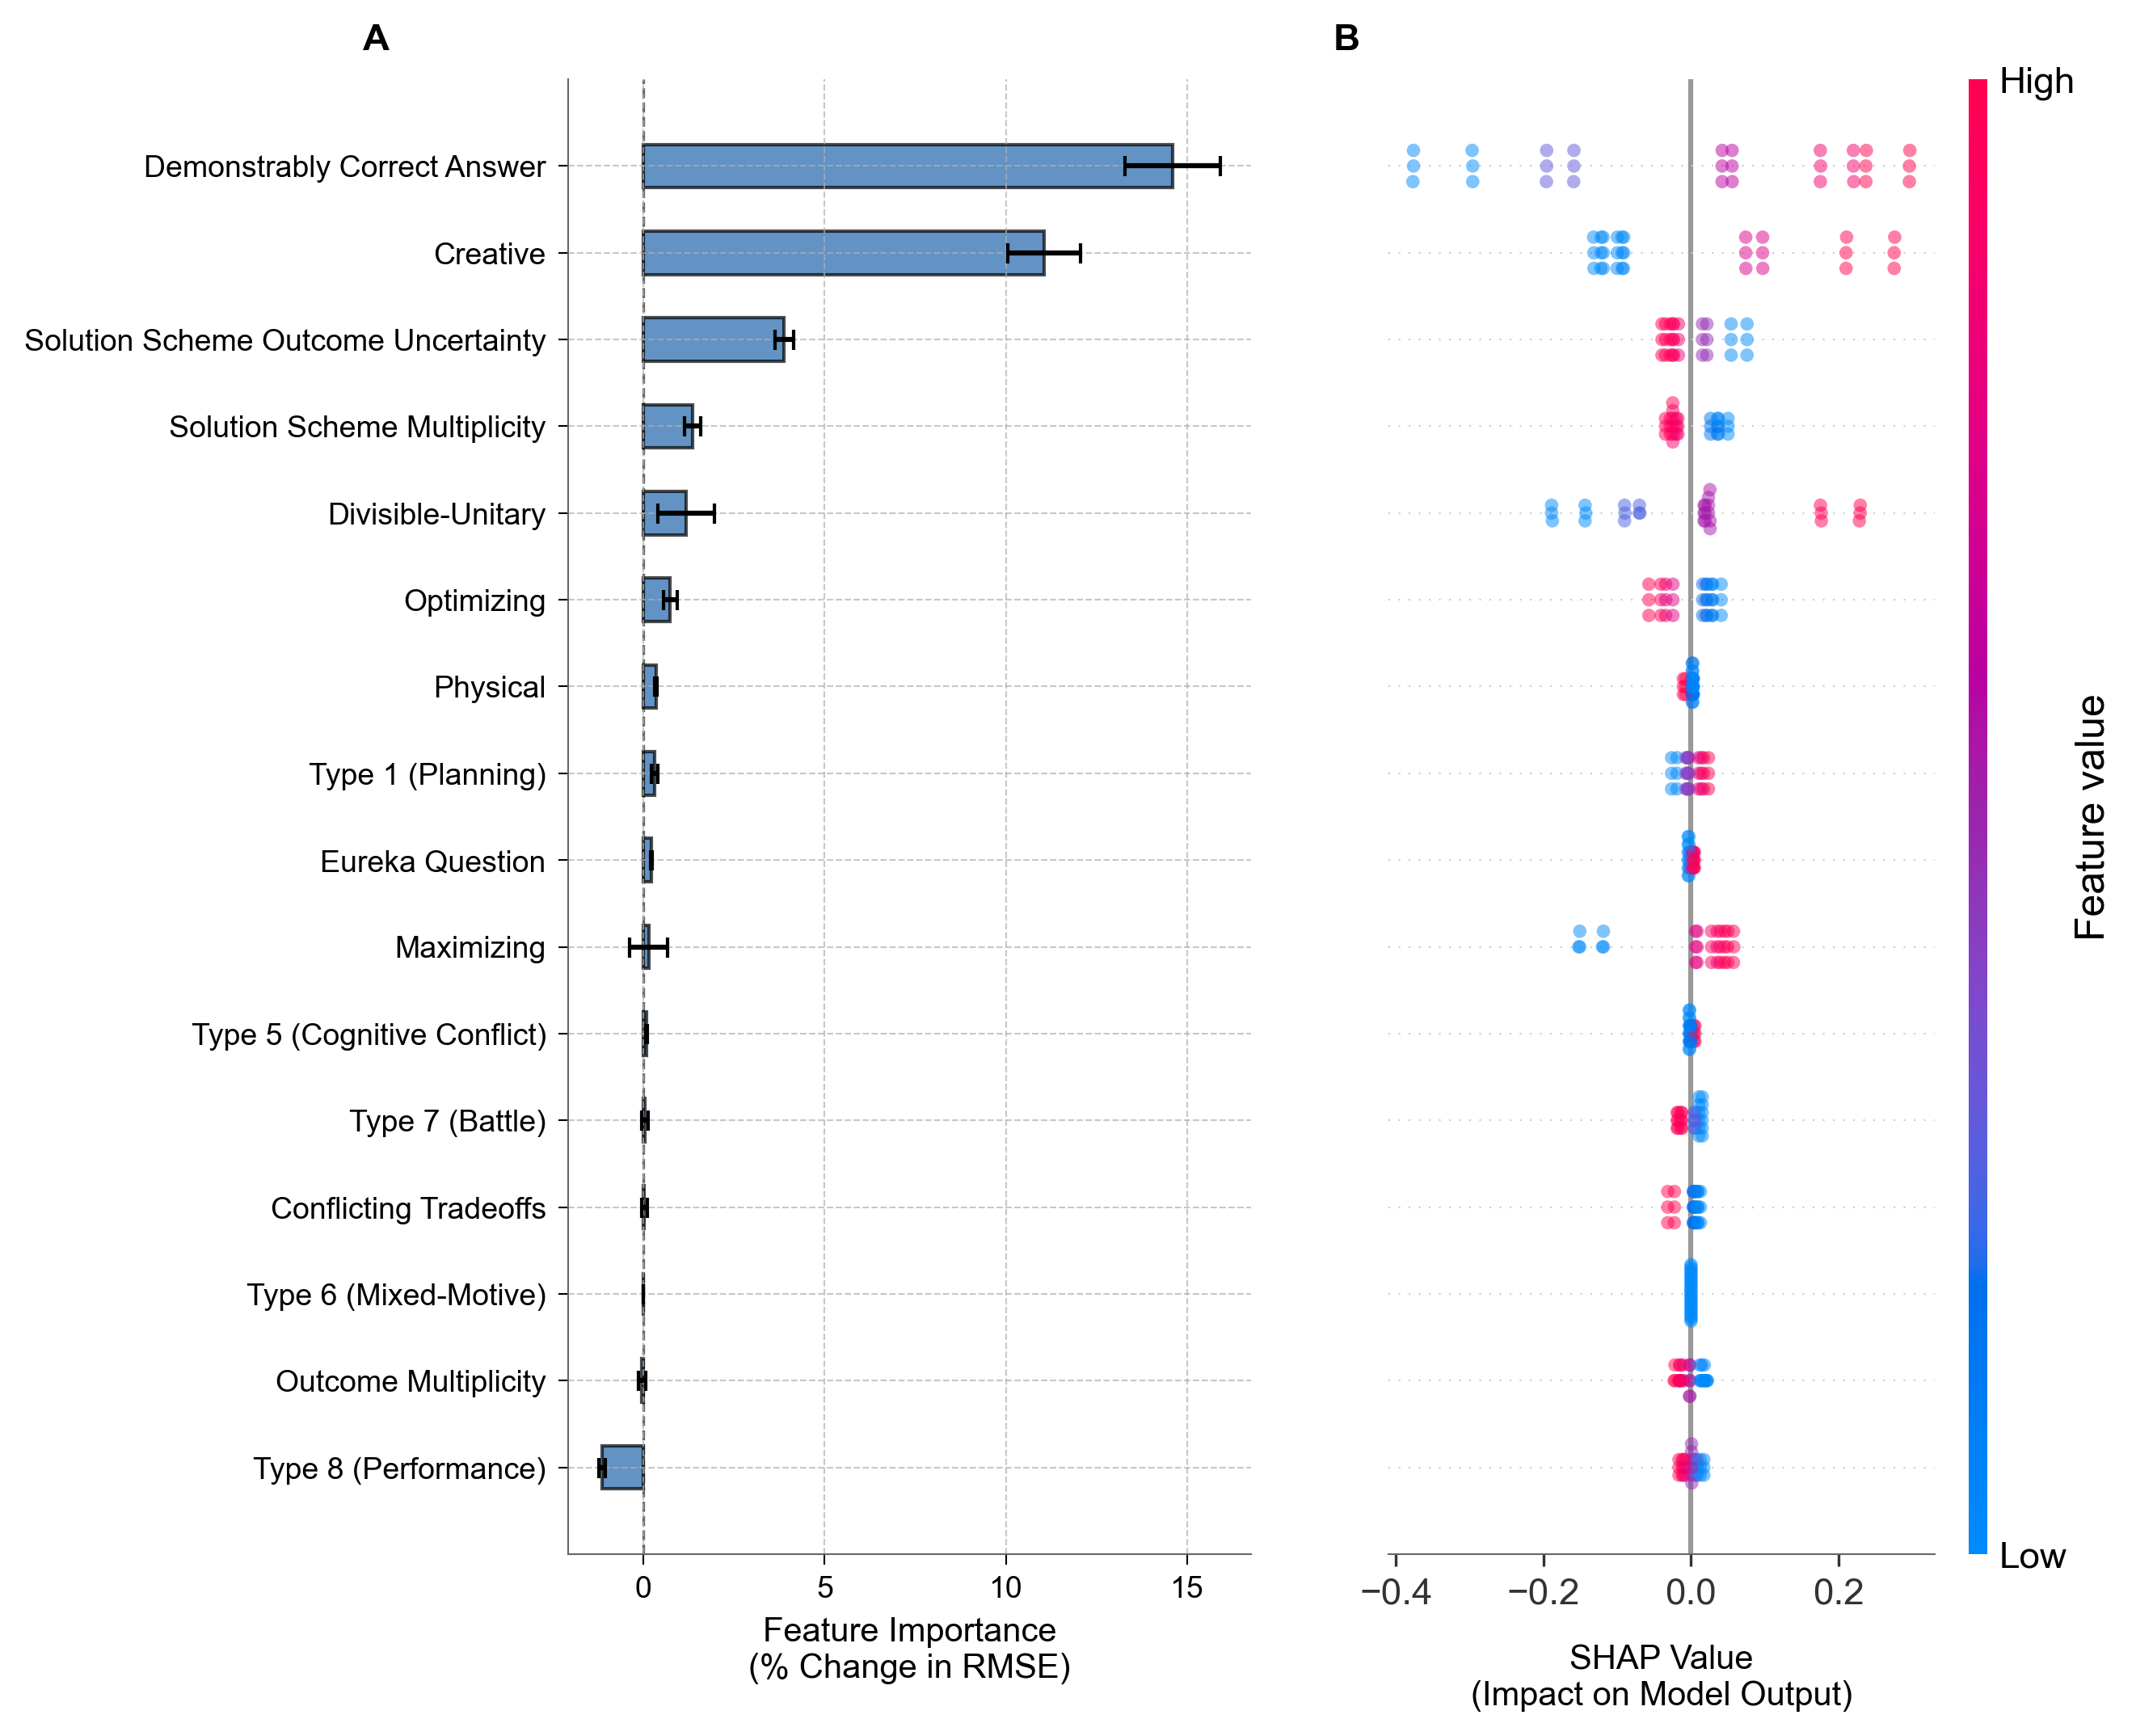

In [40]:
# ENet with interactions - Weak Synergy (Train Waves 1-2, Predict Wave 3)
plot_combined_feature_importance(
    model = MODELS["Task Space"]["E-Net"]["Wave 2"]["weak"],
    wave_a_data = TRAIN_TEST_DATA["Wave 2"]["train"],
    wave_b_data = TRAIN_TEST_DATA["Wave 2"]["test"],
    ivs = basic_IVs,
    dv_type = "weak",
    model_type = "E-Net",
    save_path = '../outputs/combined_importance_enet_weak_wave3.png'
)

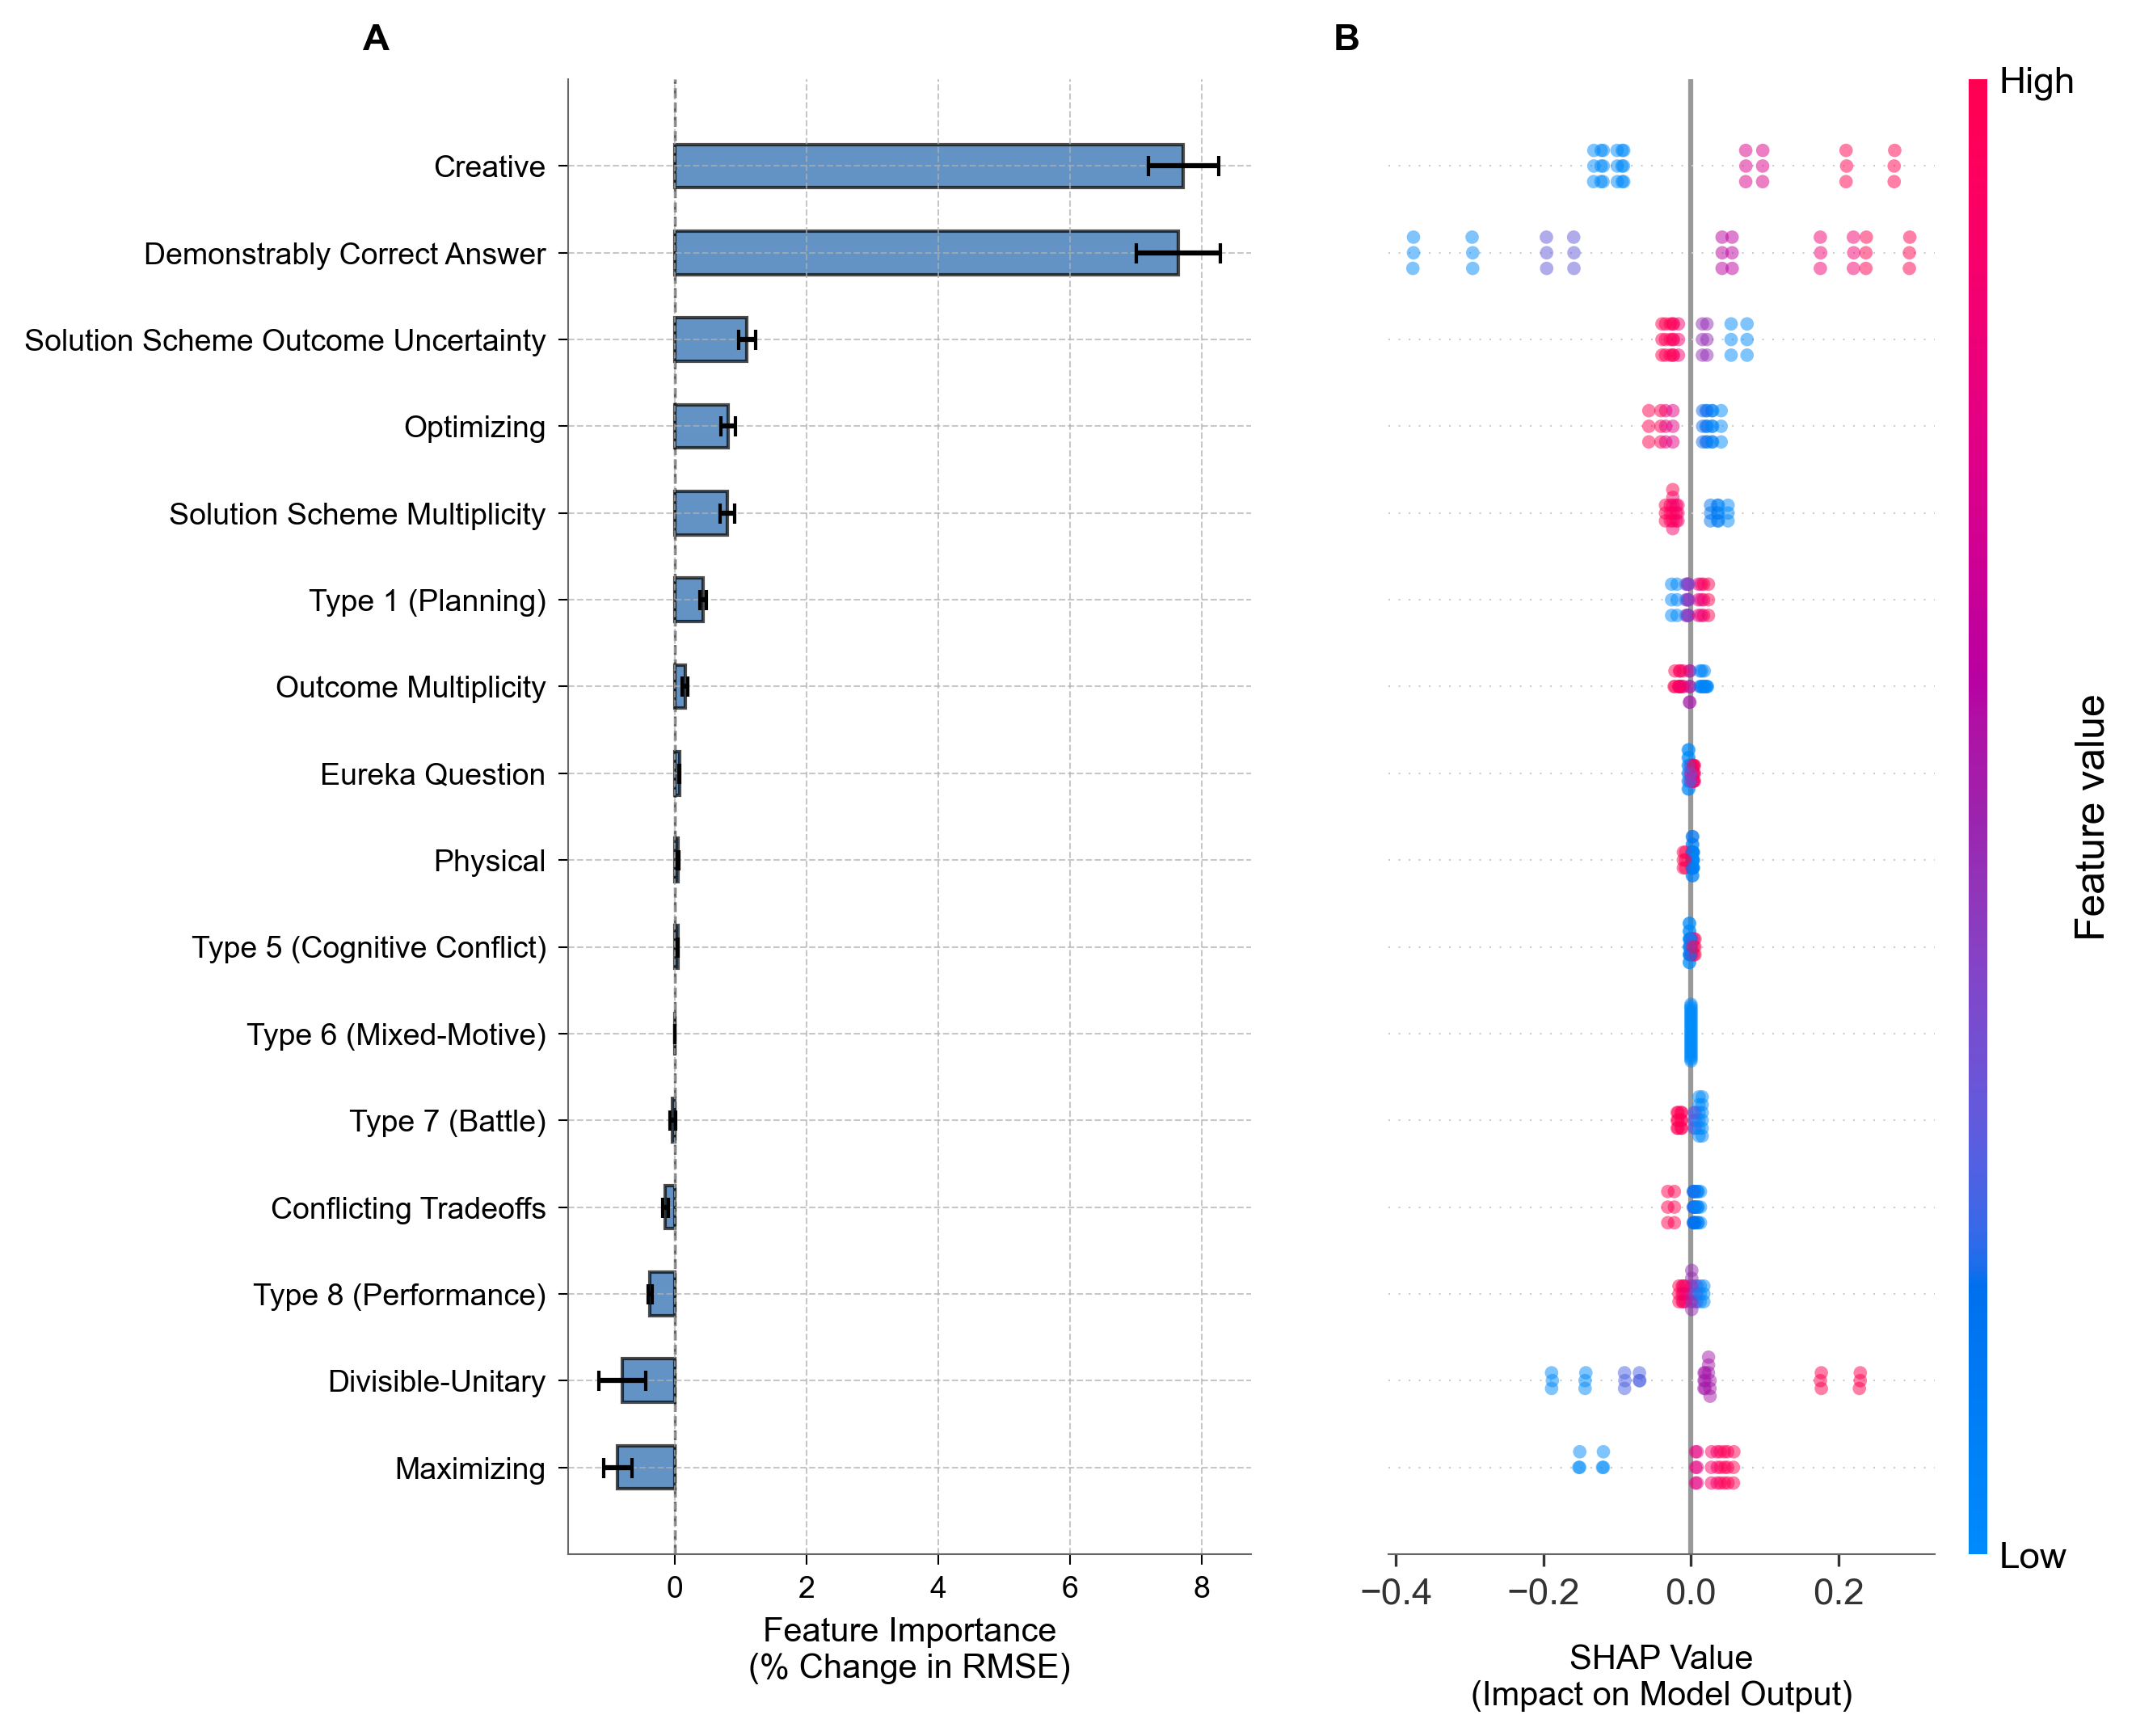

In [41]:
# Neural Network - Strong Synergy (Train Waves 1-2, Predict Wave 3)
plot_combined_feature_importance(
    model = MODELS["Task Space"]["E-Net"]["Wave 2"]["weak"],
    wave_a_data = TRAIN_TEST_DATA["Wave 2"]["train"],
    wave_b_data = TRAIN_TEST_DATA["Wave 2"]["test"],
    ivs = basic_IVs,
    dv_type = "strong",
    model_type = "E-Net",
    save_path = '../outputs/combined_importance_enet_strong_wave3.png'
)

# Check Model Predictions with Preregistration

## Train on Wave 1, Predict on Wave 2

In [42]:
# task_information_wave2 = wave2_df_condition_level_data[["task", "High", "Medium", "Low", "playerCount"]]
# weak_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Weak (Train Wave 1, Predict Wave 2)"], 
# 			  X = wave2_df_condition_level_data[basic_IVs],
# 			  model_type = "NN")
# weak_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Weak (Train Wave 1, Predict Wave 2)"], 
# 			  X = wave2_df_condition_level_data[basic_IVs],
# 			  model_type = "LM")
# strong_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Strong (Train Wave 1, Predict Wave 2)"], 
# 			  X = wave2_df_condition_level_data[basic_IVs],
# 			  model_type = "NN")
# strong_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Strong (Train Wave 1, Predict Wave 2)"], 
# 			  X = wave2_df_condition_level_data[basic_IVs],
# 			  model_type = "LM")
# # add the model predictions to the dataframe
# task_information_wave2["Weak NN Predictions"] = weak_model_predictions_nn.round(2)
# task_information_wave2["Weak LM Predictions"] = weak_model_predictions_lm.round(2)
# task_information_wave2["Strong NN Predictions"] = strong_model_predictions_nn.round(2)
# task_information_wave2["Strong LM Predictions"] = strong_model_predictions_lm.round(2)
# # add the mean of the training data to the dataframe
# task_information_wave2["Weak Baseline"] = wave1_df_condition_level_data["weak"].mean().round(2)
# task_information_wave2["Strong Baseline"] = wave1_df_condition_level_data["strong"].mean().round(2)

# # order the tasks in the following order
# order = ["Logic Problem", "Unscramble Words", "Random Dot Motion", "Recall Word Lists", "Typing"]
# task_information_wave2["task"] = pd.Categorical(task_information_wave2["task"], categories=order, ordered=True)
# task_information_wave2 = task_information_wave2.sort_values(by=["task",  "High", "Low", "Medium",  "playerCount"], ascending=[True, True, False, False, True])
# task_information_wave2.reset_index(drop=True, inplace=True)


# # merge in the original predictions
# original_preds_wave2 = pd.read_csv('../original_predictions/wave2_preds.csv').rename(columns={"Task": "task",
# 																		 "Weak_NN": "Weak NN Predictions Original",
# 																		 "Strong_NN": "Strong NN Predictions Original",
# 																		 "Weak_LM": "Weak LM Predictions Original",
# 																		 "Strong_LM": "Strong LM Predictions Original",
# 																		 "Weak_Baseline": "Weak Baseline Original",
# 																		 "Strong_Baseline": "Strong Baseline Original"})
# # get dummies for complexity in original_preds_wave2 with NO prefix
# original_preds_wave2 = pd.get_dummies(original_preds_wave2, columns=["Complexity"], prefix="", prefix_sep="")
# task_information_wave2 = pd.merge(task_information_wave2, original_preds_wave2, on=['task', 'High', 'Medium', 'Low', 'playerCount'], how='inner')

In [43]:
# def plot_prediction_differences(task_info_df, wave):
# 	pred_cols = [
# 		"Weak NN Predictions", "Weak LM Predictions",
# 		"Strong NN Predictions", "Strong LM Predictions"
# 	]
# 	original_cols = [col + " Original" for col in pred_cols]

# 	task_information_long = pd.concat([
# 		pd.DataFrame({
# 			'task': task_info_df['task'],
# 			'prediction_type': pred,
# 			'Model Predictions': task_info_df[pred],
# 			'Original Predictions': task_info_df[orig]
# 		})
# 		for pred, orig in zip(pred_cols, original_cols)
# 	], ignore_index=True)

# 	palette = sns.color_palette("viridis", len(task_info_df['task'].unique()))
# 	g = sns.FacetGrid(
# 		task_information_long, col='prediction_type', col_wrap=2, height=5, aspect=1, hue='task', palette=palette
# 	)
# 	g.map_dataframe(sns.scatterplot, x='Model Predictions', y='Original Predictions')

# 	# Add diagonal lines
# 	for ax in g.axes.flatten():
# 		max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
# 		ax.plot([0, max_val], [0, max_val], color='red', linestyle='--')

# 	g.add_legend(title="Task")
# 	g.set_titles(col_template="{col_name}")
# 	g.set_axis_labels("Model Predictions", "Original Predictions")
# 	plt.savefig('../outputs/prediction_differences_wave' + str(wave) + '.png')
# 	plt.show()

# plot_prediction_differences(task_information_wave2, wave = 2)

## Train on Waves 1-2, Predict on Wave 3

In [44]:
# task_information_wave3 = wave3_df_condition_level_data[["task", "High", "Medium", "Low", "playerCount"]]
# weak_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Weak (Train Wave 1, Predict Wave 2)"], 
# 							X = wave3_df_condition_level_data[basic_IVs],
# 								model_type = "NN")
# weak_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Weak (Train Wave 1, Predict Wave 2)"], 
# 							X = wave3_df_condition_level_data[basic_IVs],
# 							model_type = "LM")
# strong_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Strong (Train Waves 1-2, Predict Wave 3)"],
# 								X = wave3_df_condition_level_data[basic_IVs],
# 								model_type = "NN")
# strong_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Strong (Train Waves 1-2, Predict Wave 3)"],
# 								X = wave3_df_condition_level_data[basic_IVs],
# 								model_type = "LM")
# # add the model predictions to the dataframe
# task_information_wave3["Weak NN Predictions"] = weak_model_predictions_nn.round(2)
# task_information_wave3["Weak LM Predictions"] = weak_model_predictions_lm.round(2)
# task_information_wave3["Strong NN Predictions"] = strong_model_predictions_nn.round(2)
# task_information_wave3["Strong LM Predictions"] = strong_model_predictions_lm.round(2)
# # add the mean of the training data to the dataframe
# task_information_wave3["Weak Baseline"] = wave12_df_condition_level_data["weak"].mean().round(2)
# task_information_wave3["Strong Baseline"] = wave12_df_condition_level_data["strong"].mean().round(2)

# # order the tasks in the following order
# order = ["Wildcat Wells", "WildCam", "Recall Association", "Advertisement Writing", "Putting Food Into Categories"]
# task_information_wave3["task"] = pd.Categorical(task_information_wave3["task"], categories=order, ordered=True)
# task_information_wave3 = task_information_wave3.sort_values(by=["task",  "High", "Low", "Medium",  "playerCount"], ascending=[True, True, False, False, True])
# task_information_wave3.reset_index(drop=True, inplace=True)

# # merge in the original predictions
# original_preds_wave3 = pd.read_csv('../original_predictions/wave3_preds.csv').rename(columns={"Task": "task",
# 																																				 "Weak_NN": "Weak NN Predictions Original",
# 																																				 "Strong_NN": "Strong NN Predictions Original",
# 																																				 "Weak_LM": "Weak LM Predictions Original",
# 																																				 "Strong_LM": "Strong LM Predictions Original",
# 																																				 "Weak_Baseline": "Weak Baseline Original",
# 																																				 "Strong_Baseline": "Strong Baseline Original"})
# original_preds_wave3 = pd.get_dummies(original_preds_wave3, columns=["Complexity"], prefix="", prefix_sep="")
# task_information_wave3 = pd.merge(task_information_wave3, original_preds_wave3, on=['task', 'High', 'Medium', 'Low', 'playerCount'], how='inner')

In [45]:
# plot_prediction_differences(task_information_wave3, wave = 3)

# Prediction for New Conditions

In [46]:
# df_future_tasks = pd.read_csv('../future_predictions/future_tasks_for_prediction.csv')

In [47]:
# weak_model_predictions_nn_future = model_predict(fitted_model = MODELS["Task Space NN"]["Weak (Train Wave 1, Predict Wave 2)"], 
# 							X = df_future_tasks[basic_IVs],
# 								model_type = "NN")
# strong_model_predictions_nn_future = model_predict(fitted_model = MODELS["Task Space NN"]["Strong (Train Waves 1-2, Predict Wave 3)"],
# 								X = df_future_tasks[basic_IVs],
# 								model_type = "NN")

# future_predictions =  df_future_tasks[["task", "High", "Medium", "Low", "playerCount"]]
# # append the future predictions as "strong_prediction" and "weak_prediction"
# future_predictions["Weak Prediction"] = weak_model_predictions_nn_future.round(2)
# future_predictions["Strong Prediction"] = strong_model_predictions_nn_future.round(2)

In [48]:
# future_predictions.to_csv('../future_predictions/future_tasks_predictions.csv')